# 2D Distance Properties Plots

### Importing Tables

In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt


import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import binned_statistic

import seaborn as sns

import statsmodels.api as sm

from scipy import stats

#HyperFit

import sys 
sys.path.insert(1, r"C:\Users\caeho\OneDrive\Documents\University of Rochester REU\HyperFit\src")
from hyperfit.linfit import LinFit



In [2]:
dwarf_table = Table.read('dwarf_table.txt', format = 'ascii.commented_header')
dwarf_table[:5]

<Table length=5>
  aimc  IN_DR7_LSS ... 3D_neighbor_ID_vir 3D_neighbor_dist_vir
float64  float64   ...       int64              float64       
------- ---------- ... ------------------ --------------------
    0.0        1.0 ...                208   2.3657856725525463
 106.68        1.0 ...             585700   3.7385754919749274
    0.0        1.0 ...             585695   2.8927174640703734
 199.39        1.0 ...             639857    7.109919536505821
    0.0        1.0 ...             585714    2.125689993784549

In [3]:
errors_table = Table.read('errors_CMD_table.txt', format = 'ascii.commented_header')
errors_table[:5]

<Table length=5>
      u_r_err             sSFR_err      CMD_class  ELPETRO_AMIVAR_r    ID 
      float64             float64         int64        float64       int64
-------------------- ------------------ --------- ------------------ -----
0.019818080589175224                nan       -99      2487.77734375     0
 0.20073120296001434  1.169804573059082         2  2198.116455078125     1
  0.1061379536986351                nan       -99    1406.6728515625     2
 0.22668667137622833 1.3031730651855469         3  128.3397674560547     3
 0.24533124268054962                nan       -99 1161.7567138671875     4

In [4]:
dwarf_table = join(dwarf_table, errors_table, join_type = 'left', keys = 'ID')

In [5]:
dwarf_table

<Table length=12950>
  aimc  IN_DR7_LSS         RA         ... CMD_class  ELPETRO_AMIVAR_r 
float64  float64        float64       ...   int64        float64      
------- ---------- ------------------ ... --------- ------------------
    0.0        1.0 147.17645340393182 ...         2 1759.3416748046875
 106.68        1.0 146.85676432411947 ...         1    705.89501953125
    0.0        1.0 146.19277353258968 ...         1 1947.9483642578125
 199.39        1.0 146.00780426178756 ...         1   2423.86083984375
    0.0        1.0  146.6190367018052 ...         1   2307.06201171875
  21.37        1.0 146.28299647851426 ...         2 1595.2012939453125
    0.0        1.0  145.3209420527222 ...         2 1937.6204833984375
  -99.0        1.0  145.4212238164792 ...       -99                0.0
    0.0        1.0 146.26576246056774 ...         1  200.1648712158203
    2.0        1.0  146.0454337391056 ...         2  2247.967529296875
    ...        ...                ... ...       ...                ...
    0.0        1.0 185.11534575536984 ...         1  2338.910400390625
  -99.0        1.0  188.9990109305703 ...       -99  257.5990295410156
  -99.0        1.0 192.64431301412273 ...       -99 1435.1365966796875
  -99.0        1.0 191.06097499950573 ...       -99                0.0
  -99.0        1.0 192.80763257494428 ...       -99                0.0
  -99.0        1.0 188.89380818960447 ...       -99                0.0
  -99.0        1.0  195.7974241855557 ...       -99 1452.9234619140625
  -99.0        1.0 199.29944584044983 ...       -99   1029.55712890625
    2.0        1.0 201.71723972959848 ...         2   1340.06494140625
  -99.0        1.0  210.0654273046183 ...       -99  73.43338775634766

In [3]:
# gal_table = Table.read('gal_table.txt', format = 'ascii.commented_header')
# gal_table[:5]

## Getting values for Difference in Metallicity and N/O Ratio (Target - Neighboring)

In [7]:
t3mask = dwarf_table['t3'] < 3  # Makes a boolean selection mask (numpy array)
dwarf_t3= dwarf_table[t3mask]

In [5]:
#creating the new columns
dwarf_t3['2D_Z12logOH_diff'] = np.nan
dwarf_t3['2D_logNO_diff'] = np.nan

In [7]:
# for i in range(len(dwarf_t3)):
    
#     di = gal_table['ID#'] == dwarf_t3['2D_neighbor_ID'][i] #finding 2D neighboring galaxy in the large table
    
#     dwarf_t3['2D_Z12logOH_diff'][i] = dwarf_t3['Z12logOH'][i] - gal_table['Z12logOH'][di]
#     dwarf_t3['2D_logNO_diff'][i] = dwarf_t3['logNO'][i] - gal_table['logNO'][di]

In [8]:
# Separating into Void, Wall, or Other Dwarf Galaxies

dwarf_wall = dwarf_table['vflag_VF']==0
dwarf_void = dwarf_table['vflag_VF']==1
dwarf_other = ~(dwarf_wall | dwarf_void)


dwarf_wall_t3 = dwarf_t3['vflag_VF']==0
dwarf_void_t3 = dwarf_t3['vflag_VF']==1
dwarf_other_t3 = ~(dwarf_wall_t3 | dwarf_void_t3)

## Profile Histogram Function

In [9]:
def profilehist(x, y, w=None, bins=10, uncertainty='stderr'):
    """Compute a profile histogram given x, y and optional weights.
    
    Parameters
    ----------
    x : (N,) array_like
        Sequence of values to be binned.
    y : (N,) array_like
        Data on which the statistic will be computed.
    w : None or (N,) array_like
        Weights for each data point y.
    bins : int or array_like
        If int, define equal-length bins given by data min/max range; else, user-defined bin edges.
    uncertainty : str
        'stderr' to compute standard error on the mean; 'sample' for sample uncertainty
        
    Returns
    -------
    xc : array of dtype float
        Bin centers in x.
    yavg : array of dtype float
        Average in each bin.
    yerr : array of dtype float
        Uncertainty in each bin (sample error or error on the mean).
    """
    # Default to equal weights in each bin.
    if w is None:
        w = np.ones_like(y, dtype=np.float64)

    # Compute weighted sums and construct the weighted means and uncertainties.
    (Y, E, W), edges, idx = binned_statistic(x, [w*y, w*y**2, w], bins=bins, statistic='sum')
    yavg = Y/W
    ystd = np.sqrt(E/W - yavg**2)
    yerr = ystd/np.sqrt(W)

    # Compute bin centers.
    xc = 0.5*(edges[1:] + edges[:-1])
    
    if uncertainty == 'sample':
        return xc, yavg, ystd
    elif uncertainty == 'stderr':
        return xc, yavg, yerr
    else:
        raise ValueError(f'uncertainty={uncertainty} unknown; allowed: "stderr" and "sample"')

# Profile Historgrams and Linear Regressions

## Color (u-r)


### Profile Histogram

In [10]:
sfd = dwarf_table['BPTclass'] == 1
sfd_t3 = dwarf_t3['BPTclass'] == 1

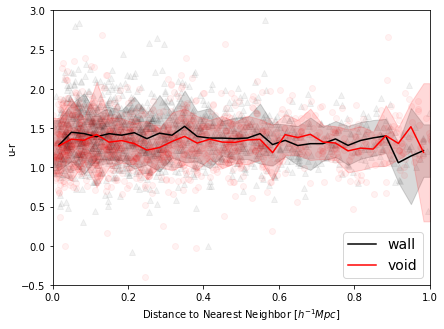

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)

plt.rcParams.update({'font.size': 14})

for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    gal_plt = dwarf_table[select & sfd]
    #gal_plt = dwarf_table[select]
    
    d = gal_plt['2D_neighbor_dist'] #dwarf_table['2D_neighbor_dist'][select & sfd]
    vals = gal_plt['u_r'] #dwarf_table['u_r'][select & sfd]
    nonan = ~np.isnan(vals)
    bins = np.linspace(0,1,31)
    

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=bins, uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)
    
    #smoothed = sm.nonparametric.lowess(vals, d, frac = 0.01, it=10)
    
    #ax.plot(smoothed[0], smoothed[1], c)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='u-r', xlim=([0,1]), ylim=([-0.5,3]));
    ax.legend();

    fig.savefig('sfd_ur_2D_PH.png')
    #fig.savefig('ur_2D_PH.png')
    
    #print(len(d))

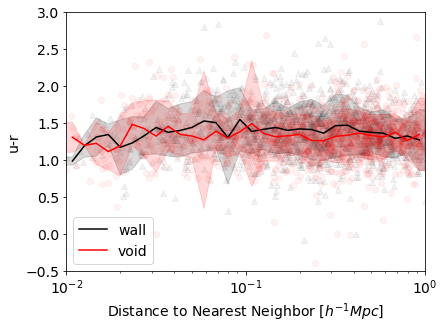

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_table['2D_neighbor_dist'][select & sfd]
    vals = dwarf_table['u_r'][select & sfd]
    
    #d = dwarf_table['2D_neighbor_dist'][select]
    #vals = dwarf_table['u_r'][select]
    
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.logspace(np.log10(0.01),np.log10(1),31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='u-r', xlim=([0.01,1]), ylim=([-0.5,3]));
    ax.set_xscale('log') #changing x axis to a logarithmic scale

    ax.legend();

    fig.savefig('sfd_ur_2D_PH_log.png')
    #fig.savefig('ur_2D_PH_log.png')

### Linear Regression

#### Fould the linear equation by following this code: https://www.reddit.com/r/learnpython/comments/ho60se/seaborn_regplot_with_linear_regression_equation/



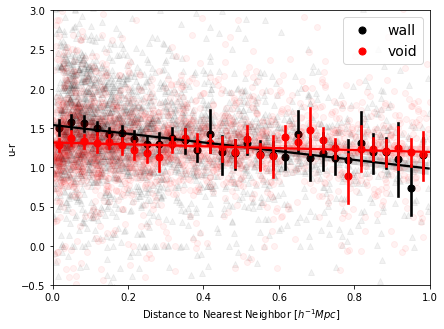

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)

plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_table['2D_neighbor_dist'][select & sfd]
    #vals_all = dwarf_table['u_r'][select & sfd]
    
    d_all = dwarf_table['2D_neighbor_dist'][select]
    vals_all = dwarf_table['u_r'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
        
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='u-r', xlim=(0,1), ylim=(-0.5,3));
        
    ax.legend()
        
    #fig.savefig('sfd_ur_2D_LR.png')
    
    #fig.savefig('ur_2D_LR.png')

### Copy of above linear regression to test finding the linear regression equation

# Test code for Color Hyperfit plot 

In [12]:
#ndata = len(dwarf_table['u_r_err'])

#need to add something like this
'''mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    vals_err = vals_all_err[mask]'''

neigh_dist2d = dwarf_table[dwarf_wall]['2D_neighbor_dist'].value
u_r  = dwarf_table[dwarf_wall]['u_r'].value
du_r = dwarf_table[dwarf_wall]['u_r_err'].value

# Cut out the NaNs from the dwarf table.
select = ~np.isnan(u_r) & ~np.isnan(du_r) & (neigh_dist2d <= 1.)

neigh_dist2d = neigh_dist2d[select]
u_r  = u_r[select]
du_r = du_r[select]

#only look at values up to 1 Mpc/h (Do I need to add this?)
'''
mask = (neigh_dist2d > 0) & (neigh_dist2d <= 1)

neigh_dist2d = neigh_dist2d[mask]
u_r  = u_r[mask]
du_r = du_r[mask]
'''
    
ndata = len(u_r)
cov = np.empty((2, 2, ndata))
data = np.empty((2, ndata))

# Pack data into 2xN array and covariances into 2x2xN array.
for i, (_dist, _u_r, _du_r) in enumerate(zip(neigh_dist2d, u_r, du_r)):        
    data[0,i] = _dist
    data[1,i] = _u_r
    cov[:,:,i] = np.array([[0., 0.], [0., _du_r**2]])

In [13]:
len(du_r)

2224

In [14]:
np.sum(np.sqrt(cov[1,1]) / data[1] > 5)

2

#### Quick Sanity Check of the Data

Make sure the data are being packed correctly into the structures `data` and `cov`.

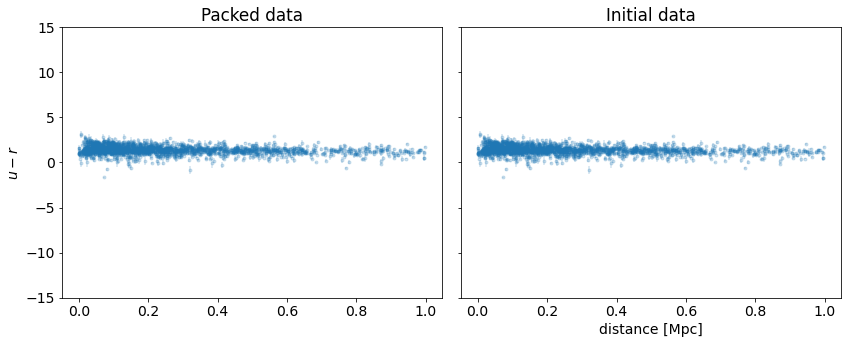

In [15]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.errorbar(data[0], data[1], yerr=np.sqrt(cov[1,1]), fmt='.', alpha=0.2)
ax.set(ylabel='$u-r$',
       title='Packed data')

ax = axes[1]
ax.errorbar(neigh_dist2d, u_r, yerr=du_r, fmt='.', alpha=0.2)
ax.set(xlabel='distance [Mpc]',
       title='Initial data',
       ylim=(-15,15));

#### Make Profile Histograms of the Selected Data

Text(0.5, 0, '$\\sigma_{u-r}/(u-r)$')

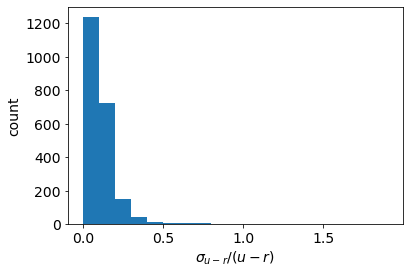

In [16]:
# Check distribution of relative uncertainties on u-r.
u_r_err_rel = du_r / np.abs(u_r)
plt.hist(u_r_err_rel, bins=np.arange(0, 2, 0.1))
plt.ylabel('count')
plt.xlabel(r'$\sigma_{u-r}/(u-r)$')

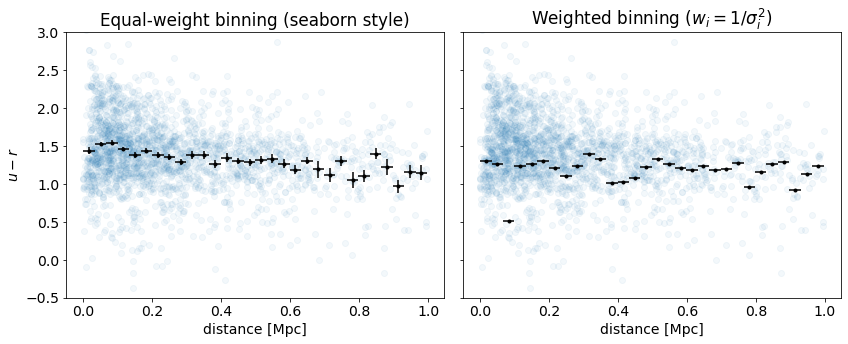

In [17]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
# dist, u_r_avg, u_r_err = profilehist(neigh_dist2d, u_r, w=1./du_r**2, bins=30, uncertainty='sample')
dist, u_r_avg, u_r_err = profilehist(neigh_dist2d, u_r, bins=30, uncertainty='stderr')
dist_err = 0.5*np.diff(dist)[0]
ax.scatter(neigh_dist2d, u_r, alpha=0.05)
ax.errorbar(dist, u_r_avg, xerr=dist_err, yerr=u_r_err, fmt='k.')
ax.set(ylim=(-0.5,3),
       ylabel='$u-r$',
       xlabel='distance [Mpc]',
       title='Equal-weight binning (seaborn style)')

ax = axes[1]
dist, u_r_avg, u_r_err = profilehist(neigh_dist2d, u_r, w=1./du_r**2, bins=30, uncertainty='stderr')
# dist, u_r_avg, u_r_err = profilehist(neigh_dist2d, u_r, bins=30, uncertainty='stderr')
dist_err = 0.5*np.diff(dist)[0]
ax.scatter(neigh_dist2d, u_r, alpha=0.05)
ax.errorbar(dist, u_r_avg, xerr=dist_err, yerr=u_r_err, fmt='k.')
ax.set(ylim=(-0.5,3),
       xlabel='distance [Mpc]',
       title=r'Weighted binning ($w_i=1/\sigma_i^2$)');

#### Try Cleaning to Keep Points with Small Relative Uncertainties

Keep only points with relative uncertainties below 10%.

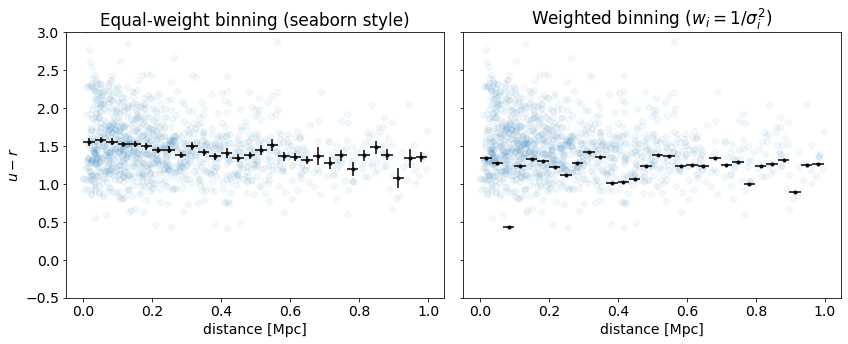

In [18]:
select = du_r / np.abs(u_r) < 0.1
neigh_dist2d_clean = neigh_dist2d[select]
u_r_clean = u_r[select]
du_r_clean = du_r[select]

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
# dist, u_r_avg, u_r_err = profilehist(neigh_dist2d, u_r, w=1./du_r**2, bins=30, uncertainty='sample')
dist, u_r_avg, u_r_err = profilehist(neigh_dist2d_clean, u_r_clean, bins=30, uncertainty='stderr')
dist_err = 0.5*np.diff(dist)[0]
ax.scatter(neigh_dist2d_clean, u_r_clean, alpha=0.05)
ax.errorbar(dist, u_r_avg, xerr=dist_err, yerr=u_r_err, fmt='k.')
ax.set(ylim=(-0.5,3),
       ylabel='$u-r$',
       xlabel='distance [Mpc]',
       title='Equal-weight binning (seaborn style)')

ax = axes[1]
dist, u_r_avg, u_r_err = profilehist(neigh_dist2d_clean, u_r_clean, w=1./du_r_clean**2, bins=30, uncertainty='stderr')
# dist, u_r_avg, u_r_err = profilehist(neigh_dist2d, u_r, bins=30, uncertainty='stderr')
dist_err = 0.5*np.diff(dist)[0]
ax.scatter(neigh_dist2d_clean, u_r_clean, alpha=0.05)
ax.errorbar(dist, u_r_avg, xerr=dist_err, yerr=u_r_err, fmt='k.')
ax.set(ylim=(-0.5,3),
       xlabel='distance [Mpc]',
       title=r'Weighted binning ($w_i=1/\sigma_i^2$)');

### Attempt to Fit the Data with `hyperfit`

In [19]:
hf = LinFit(data, cov)
print(hf)

In [20]:
bounds = ((-10,10), (-10,10), (1e-5,5))
# bounds = ((-0.1,0.1), (-1,2), (1e-5,5))
result = hf.optimize(bounds, verbose=True)
result

     fun: array([-2187.10784727])
     jac: array([-0.13687895, -0.0430191 , -0.02078195])
 message: 'Optimization terminated successfully.'
    nfev: 2458
     nit: 53
 success: True
       x: array([0.45847737, 0.06302852, 0.22575063])


(array([-7.27412612,  3.39805075]), 1.6585156789949722, 2187.1078472686595)

In [21]:
#bounds = ((-1,1), (1,2), (1e-5,5))
#bounds = ((-10.0, 10.0), (-1000.0, 1000.0), (1.0e-5, 500.0))
mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

     fun: array([-2187.10785037])
     jac: array([ 0.0080945 , -0.00991349,  0.01832632])
 message: 'Optimization terminated successfully.'
    nfev: 1979
     nit: 42
 success: True
       x: array([0.45851706, 0.06304742, 0.22575062])


100%|██████████| 1000/1000 [00:01<00:00, 574.11it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [27.08472866 27.13962213 31.94073721] / 1597.0368605591293


100%|██████████| 1000/1000 [00:01<00:00, 588.77it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [33.5444592  33.47669575 38.60239206] / 1930.1196028247855


100%|██████████| 1000/1000 [00:01<00:00, 606.26it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.74446183 43.38627137 39.54139757] / 2237.223091564626


100%|██████████| 1000/1000 [00:01<00:00, 609.45it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.85187419 41.98979563 37.57518666] / 2192.5937092557765


100%|██████████| 1000/1000 [00:01<00:00, 607.82it/s]

Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.71286068 42.56777255 36.81625118] / 2185.6430337525585
[-7.31892628  3.40922281  1.67004599] [0.65813737 0.18426012 0.15167241]


### Plot the Hyperfit
After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in distance and u_r, and the color given by the best-fit scatter parameter sigma_i.

Code taken from plotting examples in hyperfit documentation.

In [22]:
#copied from Hailey's notebook

a, b, sig    = np.mean(mcmc_samples, axis=1)
da, db, dsig = np.std(mcmc_samples, axis=1)
labels = ['a', 'b', 'sigma']

for label, val, err in zip(labels, (a, b, sig), (da, db, dsig)):
    print('{:6s}= {:6.3f} +/- {:.3f}'.format(label, val, err))

a     = -7.319 +/- 0.658
b     =  3.409 +/- 0.184
sigma =  1.670 +/- 0.152


In [84]:
import cmocean

ModuleNotFoundError: No module named 'cmocean'

In [ ]:
# copy of code from hyperfit tutorial

'''import matplotlib.pyplot as plt

xvals = np.linspace(0, 1, 1000)
y_bestfit = np.outer(xvals, hf.coords[0]) + hf.coords[1]
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_upper = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1] + mcmc_samples[2]
y_lower = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1] - mcmc_samples[2]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)
y_upper_quantiles = np.quantile(y_upper, [0.1587, 0.8414], axis=1)
y_lower_quantiles = np.quantile(y_lower, [0.1587, 0.8414], axis=1)

fig = plt.figure()
ax = fig.add_axes([0.15, 0.13, 0.83, 0.85])
ax.errorbar(data[0], data[1], xerr=x_err, yerr=y_err, c="k", mfc="b", marker="s", ls="None", alpha=0.8)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.5)
ax.fill_between(xvals, y_upper_quantiles[0], y_upper_quantiles[1], color="k", alpha=0.3)
ax.fill_between(xvals, y_lower_quantiles[0], y_lower_quantiles[1], color="k", alpha=0.3)
ax.plot(xvals, y_bestfit, ls="-", c="k")
ax.plot(xvals, y_bestfit + hf.vert_scat, ls="--", c="k")
ax.plot(xvals, y_bestfit - hf.vert_scat, ls="--", c="k")
ax.set_xlabel(r"$x$", fontsize=16)
ax.set_ylabel(r"$y$", fontsize=16)
ax.set_xlim(-0.3, 1.3)
ax.set_ylim(0.5, 3.7)
plt.show()'''

In [23]:
from corner import corner

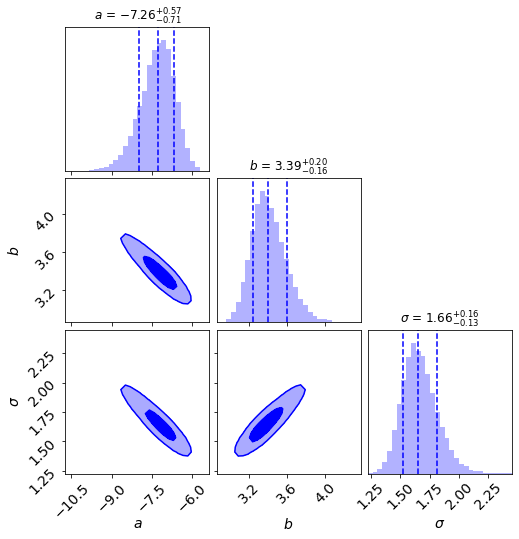

In [24]:
fig = corner(mcmc_samples.T, bins=30, smooth=1,
             # range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})

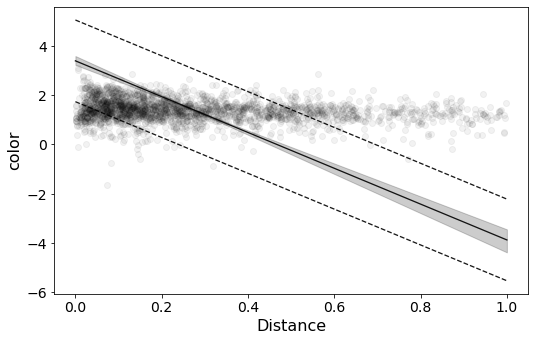

In [25]:
#plotting code based off of Hailey's notebook

from matplotlib.patches import Ellipse

nbins = 100
sigmas = hf.get_sigmas()
xvals = np.linspace(0, 1, nbins)
yvals = hf.coords[0] * xvals + hf.coords[1]
#yvals = hf.coords[1]

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = data #[log10vmax[isrmeas], rmag[isrmeas]]
x_err = np.full(3505, (1/nbins)) #np.ones(3505) #dlog10vmax[isrmeas]
#x_err = np.full(3080, (1/nbins)) #when masking values above 1 Mpc/h
y_err = du_r #drmag[isrmeas]
corr_xy = np.zeros_like(x_err)

# Generate ellipses
# ells = [
#     Ellipse(
#         #xy=[data[0][i], data[1][i]],
#         xy=[xvals[i], yvals[i]],
#         width=2.0 * y_err[i],
#         height=2.0 * x_err[i],
#         angle=np.rad2deg(np.arccos(corr_xy[i])),
#     )
#     #for i in range(len(data[0]))
#     for i in range(len(xvals))
# ]

# Make the plot
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
# for i, e in enumerate(ells):
#     ax.add_artist(e)
#     #e.set_color(cmocean.cm.thermal(sigmas[i] / np.amax(sigmas)))
#     e.set_edgecolor('None')
#     e.set_alpha(0.9)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)
#ax.set_title(r"Coma", fontsize = 16)
# ax.set_xlim(0, 3)
# ax.set_ylim(-0., 3)

ax.scatter(data[0], data[1], alpha=0.05, color='k', marker='o') #plotting the actual scatter

# Add the colourbar
#cb = fig.colorbar(
    #cm.ScalarMappable(norm=colors.Normalize(vmin=0.0, vmax=np.amax(sigmas)), cmap = cmocean.cm.thermal),
    #ax=ax,
    #shrink=0.5,
    #aspect=10,
    #anchor=(-8, 0.95),
#)
#b.set_label(label=r"$\sigma$", fontsize=14)

# Using Profile Histogram Function for HyperFit

### Testing with wall dwarf galaxies for color

In [26]:
neigh_dist2d = dwarf_table[dwarf_wall]['2D_neighbor_dist'].value
u_r  = dwarf_table[dwarf_wall]['u_r'].value
du_r = dwarf_table[dwarf_wall]['u_r_err'].value

# Cut out the NaNs from the dwarf table.
select = ~np.isnan(u_r) & ~np.isnan(du_r) & (neigh_dist2d <= 1.)

neigh_dist2d = neigh_dist2d[select]
u_r  = u_r[select]
du_r = du_r[select]


#### Option: Try Cleaning to Keep Points with Small Relative Uncertainties

Keep only points with relative uncertainties below 10%.

In [27]:
select = du_r / np.abs(u_r) < 0.1
neigh_dist2d_clean = neigh_dist2d[select]
u_r_clean = u_r[select]
du_r_clean = du_r[select]

## Key

#### c_ = cleaned data
#### w_ = weighted raw data
#### cw_ = cleaned weighted data

## Profile Histogram with Equal Weight Binning

Cleaned data

In [28]:
c_dist, c_u_r_avg, c_u_r_err = profilehist(neigh_dist2d_clean, u_r_clean, bins=30, uncertainty='stderr')
c_dist_err = 0.5*np.diff(dist)[0] #unsure if this error is actually the size of the bin

Raw data

In [29]:
dist, u_r_avg, u_r_err = profilehist(neigh_dist2d, u_r, bins=30, uncertainty='stderr')
dist_err = 0.5*np.diff(dist)[0]

In [30]:
len(u_r_err)

30

## Profile Histogram with Weighted Binning $w_i=1/\sigma_i^2$

In [31]:
cw_dist, cw_u_r_avg, cw_u_r_err = profilehist(neigh_dist2d_clean, u_r_clean, w=1./du_r_clean**2, bins=30, uncertainty='stderr')

cw_dist_err = 0.5*np.diff(dist)[0]

In [32]:
w_dist, w_u_r_avg, w_u_r_err = profilehist(neigh_dist2d, u_r, w=1./du_r**2, bins=30, uncertainty='stderr')

w_dist_err = 0.5*np.diff(dist)[0]

## Packing Data into format for Hyperfit

In [33]:
ndata = len(u_r_avg)
cov = np.empty((2, 2, ndata))
data = np.empty((2, ndata))

# Pack data into 2xN array and covariances into 2x2xN array.
for i, (_dist, _u_r, _du_r) in enumerate(zip(dist, u_r_avg, u_r_err)):        
    data[0,i] = _dist
    data[1,i] = _u_r
    cov[:,:,i] = np.array([[0., 0.], [0., _du_r**2]])   
    

In [34]:
c_ndata = len(c_u_r_avg)
c_cov = np.empty((2, 2, ndata))
c_data = np.empty((2, ndata))

# Pack data into 2xN array and covariances into 2x2xN array.
for i, (_dist, _u_r, _du_r) in enumerate(zip(c_dist, c_u_r_avg, c_u_r_err)):        
    c_data[0,i] = _dist
    c_data[1,i] = _u_r
    c_cov[:,:,i] = np.array([[0., 0.], [0., _du_r**2]])   
    

#### Weighted Values

In [35]:
w_ndata = len(w_u_r_avg)
w_cov = np.empty((2, 2, ndata))
w_data = np.empty((2, ndata))

# Pack data into 2xN array and covariances into 2x2xN array.
for i, (_dist, _u_r, _du_r) in enumerate(zip(w_dist, w_u_r_avg, w_u_r_err)):        
    w_data[0,i] = _dist
    w_data[1,i] = _u_r
    w_cov[:,:,i] = np.array([[0., 0.], [0., _du_r**2]])

In [36]:
cw_ndata = len(cw_u_r_avg)
cw_cov = np.empty((2, 2, ndata))
cw_data = np.empty((2, ndata))

# Pack data into 2xN array and covariances into 2x2xN array.
for i, (_dist, _u_r, _du_r) in enumerate(zip(cw_dist, cw_u_r_avg, cw_u_r_err)):        
    cw_data[0,i] = _dist
    cw_data[1,i] = _u_r
    cw_cov[:,:,i] = np.array([[0., 0.], [0., _du_r**2]])

### Fitting data to hyperfit

In [37]:
hf = LinFit(data, cov)
print(hf)

In [38]:
c_hf = LinFit(c_data, c_cov)
print(c_hf)

In [39]:
w_hf = LinFit(w_data, w_cov)
print(w_hf)

In [40]:
cw_hf = LinFit(cw_data, cw_cov)
print(cw_hf)

In [41]:
bounds = ((-10,10), (-10,10), (1e-5,5))
# bounds = ((-0.1,0.1), (-1,2), (1e-5,5))
result = hf.optimize(bounds, verbose=True)
result

     fun: array([-66.27330195])
     jac: array([-0.0108912 , -0.0246331 ,  0.00318181])
 message: 'Optimization terminated successfully.'
    nfev: 2503
     nit: 54
 success: True
       x: array([0.51268228, 1.29180911, 0.03383496])


(array([-0.39687155,  1.49527811]), 0.038017711175626065, 66.2733019518809)

In [42]:
c_bounds = ((-10,10), (-10,10), (1e-5,5))
# bounds = ((-0.1,0.1), (-1,2), (1e-5,5))
c_result = c_hf.optimize(c_bounds, verbose=True)
c_result

     fun: array([-69.4143973])
     jac: array([-3.41060513e-04,  5.96855902e-05,  1.00328634e-03])
 message: 'Optimization terminated successfully.'
    nfev: 2634
     nit: 57
 success: True
       x: array([4.08091189e-01, 1.42706931e+00, 7.63306110e-05])


(array([-0.28596452,  1.54376891]), 8.291359941044855e-05, 69.41439729650526)

In [43]:
w_bounds = ((-10,10), (-10,10), (1e-5,5))
# bounds = ((-0.1,0.1), (-1,2), (1e-5,5))
w_result = w_hf.optimize(w_bounds, verbose=True)
w_result

     fun: array([-38.92102594])
     jac: array([ 0.00438405,  0.00291465, -0.00156248])
 message: 'Optimization terminated successfully.'
    nfev: 2311
     nit: 50
 success: True
       x: array([-0.0056192 ,  1.17594064,  0.16559555])


(array([0.00477847, 1.17596749]), 0.1729465989376574, 38.92102594377054)

In [44]:
cw_bounds = ((-10,10), (-10,10), (1e-5,5))
# bounds = ((-0.1,0.1), (-1,2), (1e-5,5))
cw_result = cw_hf.optimize(cw_bounds, verbose=True)
cw_result

     fun: array([-35.20310614])
     jac: array([-0.00186375, -0.00132019,  0.00022879])
 message: 'Optimization terminated successfully.'
    nfev: 2221
     nit: 48
 success: True
       x: array([-0.10730766,  1.15036715,  0.18747368])


(array([0.09328123, 1.16037694]), 0.19664370153236374, 35.20310613865868)

In [45]:
mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

     fun: array([-66.27330197])
     jac: array([-0.00400462,  0.00184599, -0.00059117])
 message: 'Optimization terminated successfully.'
    nfev: 2225
     nit: 48
 success: True
       x: array([0.51266711, 1.29182059, 0.03383426])


100%|██████████| 1000/1000 [00:00<00:00, 1165.87it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [28.37461272 26.91547665 26.34240794] / 1418.7306362078118


100%|██████████| 1000/1000 [00:00<00:00, 1182.93it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [29.06646087 28.34006883 33.29381715] / 1664.690857569981


100%|██████████| 1000/1000 [00:00<00:00, 1101.69it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [29.29974201 29.35980514 44.17673592] / 2208.8367957755436


100%|██████████| 1000/1000 [00:00<00:00, 1229.97it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [31.67088853 33.73995643 48.49749109] / 2424.8745545847996


100%|██████████| 1000/1000 [00:00<00:00, 1208.36it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [36.45274306 34.49167632 42.85870507] / 2142.9352535205176


100%|██████████| 1000/1000 [00:00<00:00, 1141.27it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.17559569 35.78112737 46.4177527 ] / 2320.887635099292


100%|██████████| 1000/1000 [00:00<00:00, 1125.30it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.8086842  39.21215472 39.3677304 ] / 1990.4342100582364


100%|██████████| 1000/1000 [00:00<00:00, 1227.07it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.19446047 39.68437902 40.02280716] / 2109.723023397003


100%|██████████| 1000/1000 [00:00<00:00, 1190.86it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.74813283 40.68723983 42.07110776] / 2187.4066412639972
[-0.39737152  1.4957227   0.04162604] [0.04971662 0.02332045 0.01670316]


In [46]:
c_mcmc_samples, c_mcmc_lnlike = c_hf.emcee(c_bounds, verbose=True)
print(np.mean(c_mcmc_samples, axis=1), np.std(c_mcmc_samples, axis=1))

     fun: array([-69.41439639])
     jac: array([-0.00207194,  0.00090949,  0.00512017])
 message: 'Optimization terminated successfully.'
    nfev: 2352
     nit: 51
 success: True
       x: array([4.08084066e-01, 1.42707177e+00, 3.72390790e-04])


100%|██████████| 1000/1000 [00:00<00:00, 1145.20it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.39426772 37.7658161  56.23431689] / 2811.7158443850703


100%|██████████| 1000/1000 [00:00<00:00, 1172.48it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [34.06562718 33.35014117 42.77222665] / 2138.611332741918


100%|██████████| 1000/1000 [00:00<00:00, 1160.39it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.39492724 43.81015457 45.57846782] / 2278.92339113492


100%|██████████| 1000/1000 [00:00<00:00, 1057.03it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.17172426 46.46569048 41.66060899] / 2323.284523854817


100%|██████████| 1000/1000 [00:00<00:00, 1154.47it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.81754132 44.69743023 42.27568143] / 2390.877065914109


100%|██████████| 1000/1000 [00:00<00:00, 1232.16it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.21689793 36.48094402 45.98293936] / 2299.1469681888448


100%|██████████| 1000/1000 [00:00<00:00, 1215.99it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.65033356 35.19456015 49.84374951] / 2492.1874756857906


100%|██████████| 1000/1000 [00:00<00:00, 1159.58it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.29272676 35.15981394 54.2999861 ] / 2714.999304878735


100%|██████████| 1000/1000 [00:00<00:00, 1167.86it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.68635584 37.53720499 55.05054192] / 2752.5270960481575


100%|██████████| 1000/1000 [00:00<00:00, 1225.07it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [49.16018556 41.127137   56.67742542] / 2833.871270804487


100%|██████████| 1000/1000 [00:00<00:00, 1239.38it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.31690264 40.900844   58.7368847 ] / 2936.844234902781
[-0.28054108  1.54248607  0.02189467] [0.04336447 0.01997808 0.01480074]


In [47]:
w_mcmc_samples, w_mcmc_lnlike = w_hf.emcee(w_bounds, verbose=True)
print(np.mean(w_mcmc_samples, axis=1), np.std(w_mcmc_samples, axis=1))

     fun: array([-38.92102578])
     jac: array([-0.00640838, -0.00096207,  0.00200941])
 message: 'Optimization terminated successfully.'
    nfev: 2176
     nit: 47
 success: True
       x: array([-0.0059038 ,  1.17581338,  0.16559721])


100%|██████████| 1000/1000 [00:00<00:00, 1246.75it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.84048889 36.96575474 42.30151075] / 2142.024444575349


100%|██████████| 1000/1000 [00:00<00:00, 1242.70it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [60.26705647 54.98489928 53.91982053] / 3013.3528234739388


100%|██████████| 1000/1000 [00:00<00:00, 1244.17it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [62.8985802  58.2593183  41.17486379] / 3144.929009960922


100%|██████████| 1000/1000 [00:00<00:00, 1217.94it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [74.17391402 59.415046   41.86223005] / 3708.6957010051074


100%|██████████| 1000/1000 [00:00<00:00, 1244.05it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [66.82004125 54.72740384 41.10054702] / 3341.0020626819523


100%|██████████| 1000/1000 [00:00<00:00, 1243.81it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [64.99851028 56.81114017 38.51321435] / 3249.9255138571407


100%|██████████| 1000/1000 [00:00<00:00, 1248.96it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [62.3680187  62.34824902 40.78423301] / 3118.400935195187


100%|██████████| 1000/1000 [00:00<00:00, 1255.63it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [59.36942243 60.13789249 42.37970748] / 3006.894624320174


100%|██████████| 1000/1000 [00:00<00:00, 1247.40it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [62.10095919 63.40842414 43.43907949] / 3170.421207004555


100%|██████████| 1000/1000 [00:00<00:00, 1241.75it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [60.64069186 61.42633001 46.51561825] / 3071.3165005990213


100%|██████████| 1000/1000 [00:00<00:00, 1249.59it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [64.36275733 61.77893445 53.10939583] / 3218.1378664374747


100%|██████████| 1000/1000 [00:00<00:00, 1257.99it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [73.5955435  63.63705349 52.00974063] / 3679.7771750046486


100%|██████████| 1000/1000 [00:00<00:00, 1249.18it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [68.46418373 60.5598171  51.03228606] / 3423.2091865588754


100%|██████████| 1000/1000 [00:00<00:00, 1233.01it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [69.58450272 60.57630315 47.92648509] / 3479.2251358013636


100%|██████████| 1000/1000 [00:00<00:00, 1238.00it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [65.98449885 58.5733103  47.49314773] / 3299.224942528653


100%|██████████| 1000/1000 [00:00<00:00, 1248.13it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [72.56379426 61.36216689 46.57181876] / 3628.1897129585773


100%|██████████| 1000/1000 [00:00<00:00, 1253.71it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [69.14046486 63.49463768 48.24178152] / 3457.0232428819454
[-0.00526993  1.18176011  0.1815645 ] [0.14974292 0.08165965 0.02677661]


In [48]:
cw_mcmc_samples, cw_mcmc_lnlike = cw_hf.emcee(cw_bounds, verbose=True)
print(np.mean(cw_mcmc_samples, axis=1), np.std(cw_mcmc_samples, axis=1))

     fun: array([-35.20310625])
     jac: array([-0.00032401,  0.00055849, -0.00038369])
 message: 'Optimization terminated successfully.'
    nfev: 2106
     nit: 45
 success: True
       x: array([-0.10722682,  1.15042202,  0.18747331])


100%|██████████| 1000/1000 [00:00<00:00, 1245.91it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [51.0830057  48.83115653 32.95983682] / 2554.150285145802


100%|██████████| 1000/1000 [00:00<00:00, 1244.76it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [59.20106497 50.47078386 48.30720696] / 2960.05324858813


100%|██████████| 1000/1000 [00:00<00:00, 1245.89it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [57.42879974 48.91600577 45.39732493] / 2871.4399871247624


100%|██████████| 1000/1000 [00:00<00:00, 1185.89it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.10141457 47.28880584 44.18777474] / 2364.4402920871694


100%|██████████| 1000/1000 [00:00<00:00, 1202.51it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [53.74671836 57.14820884 40.63211592] / 2857.410441878841


100%|██████████| 1000/1000 [00:00<00:00, 1228.85it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [64.89117734 68.18252274 41.43476025] / 3409.126136881403


100%|██████████| 1000/1000 [00:00<00:00, 1244.94it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [63.45043862 63.120221   46.05361154] / 3172.5219310465213


100%|██████████| 1000/1000 [00:00<00:00, 1236.70it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [66.34370243 64.15443394 51.36530744] / 3317.1851214887356


100%|██████████| 1000/1000 [00:00<00:00, 1240.24it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [64.107686   62.48129895 48.44629819] / 3205.38430024145


100%|██████████| 1000/1000 [00:00<00:00, 1247.46it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [63.50610243 62.53004402 46.87860758] / 3175.305121660161
[0.07095939 1.17282522 0.20680557] [0.17579499 0.09446798 0.03064401]


## Plotting Hyperfit

In [49]:
# a = slope, b = intercept, sig = error on intercept

a, b, sig    = np.mean(mcmc_samples, axis=1)
da, db, dsig = np.std(mcmc_samples, axis=1)
labels = ['a', 'b', 'sigma']

for label, val, err in zip(labels, (a, b, sig), (da, db, dsig)):
    print('{:6s}= {:6.3f} +/- {:.3f}'.format(label, val, err))

a     = -0.397 +/- 0.050
b     =  1.496 +/- 0.023
sigma =  0.042 +/- 0.017


#### test to see if the slopes above change

In [466]:
# a = slope, b = intercept, sig = error on intercept

a, b, sig    = np.mean(mcmc_samples, axis=1)
da, db, dsig = np.std(mcmc_samples, axis=1)
labels = ['a', 'b', 'sigma']

for label, val, err in zip(labels, (a, b, sig), (da, db, dsig)):
    print('{:6s}= {:6.3f} +/- {:.3f}'.format(label, val, err))

a     = -0.562 +/- 0.060
b     =  1.547 +/- 0.025
sigma =  0.032 +/- 0.020


In [50]:
# a = slope, b = intercept, sig = error on intercept

c_a, c_b, c_sig    = np.mean(c_mcmc_samples, axis=1)
c_da, c_db, c_dsig = np.std(c_mcmc_samples, axis=1)
c_labels = ['c_a', 'c_b', 'c_sigma']

for c_label, c_val, c_err in zip(c_labels, (c_a, c_b, c_sig), (c_da, c_db, c_dsig)):
    print('{:6s}= {:6.3f} +/- {:.3f}'.format(c_label, c_val, c_err))

c_a   = -0.281 +/- 0.043
c_b   =  1.542 +/- 0.020
c_sigma=  0.022 +/- 0.015


In [51]:
# w_a = slope, w_b = intercept, w_sig = error on intercept

w_a, w_b, w_sig    = np.mean(w_mcmc_samples, axis=1)
w_da, w_db, w_dsig = np.std(w_mcmc_samples, axis=1)
w_labels = ['w_a', 'w_b', 'w_sigma']

for w_label, w_val, w_err in zip(w_labels, (w_a, w_b, w_sig), (w_da, w_db, w_dsig)):
    print('{:6s}= {:6.3f} +/- {:.3f}'.format(w_label, w_val, w_err))

w_a   = -0.005 +/- 0.150
w_b   =  1.182 +/- 0.082
w_sigma=  0.182 +/- 0.027


In [52]:
# w_a = slope, w_b = intercept, w_sig = error on intercept

cw_a, cw_b, cw_sig    = np.mean(cw_mcmc_samples, axis=1)
cw_da, cw_db, cw_dsig = np.std(cw_mcmc_samples, axis=1)
cw_labels = ['cw_a', 'cw_b', 'cw_sigma']

for cw_label, cw_val, cw_err in zip(cw_labels, (cw_a, cw_b, cw_sig), (cw_da, cw_db, cw_dsig)):
    print('{:6s}= {:6.3f} +/- {:.3f}'.format(cw_label, cw_val, cw_err))

cw_a  =  0.071 +/- 0.176
cw_b  =  1.173 +/- 0.094
cw_sigma=  0.207 +/- 0.031


#### Corner Plot

In [53]:
from corner import corner

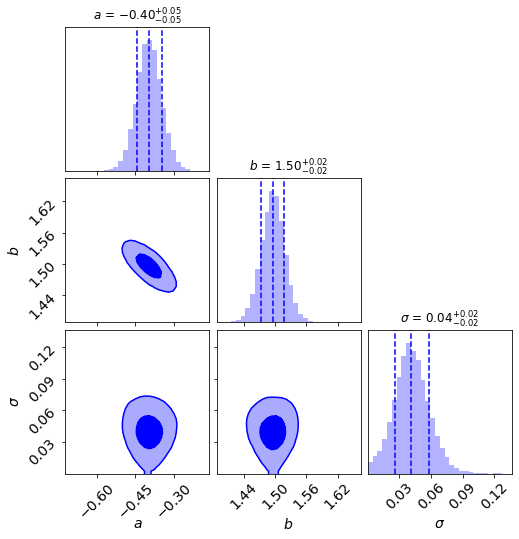

In [54]:
fig = corner(mcmc_samples.T, bins=30, smooth=1,
             # range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})

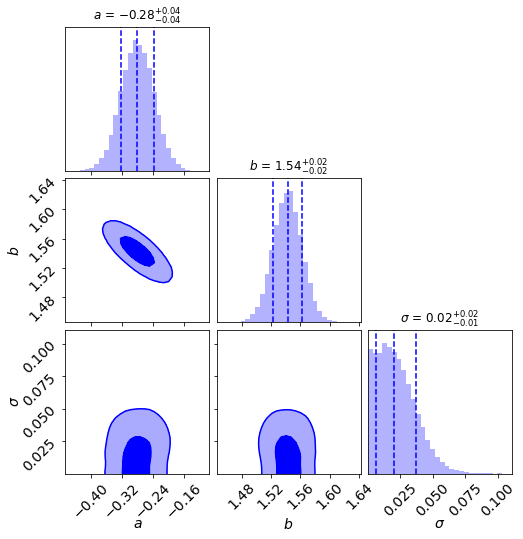

In [55]:
fig = corner(c_mcmc_samples.T, bins=30, smooth=1,
             # range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})

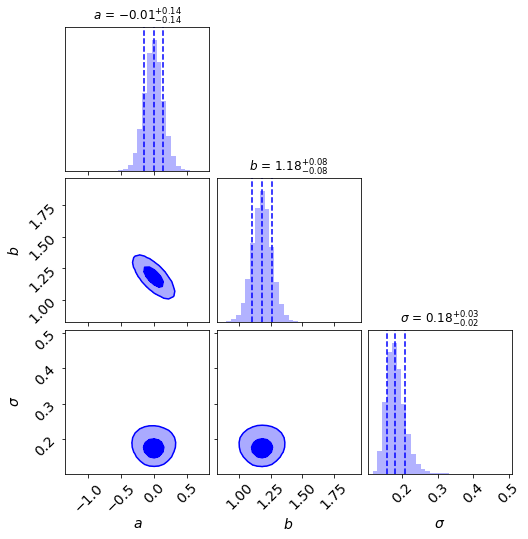

In [56]:
fig = corner(w_mcmc_samples.T, bins=30, smooth=1,
             # range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})

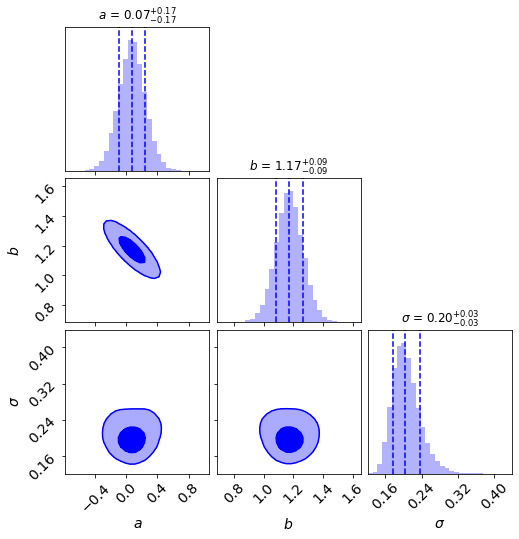

In [57]:
fig = corner(cw_mcmc_samples.T, bins=30, smooth=1,
             # range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})

### Making Plot

Text(0.5, 1.0, 'Equal-Weight Bins')

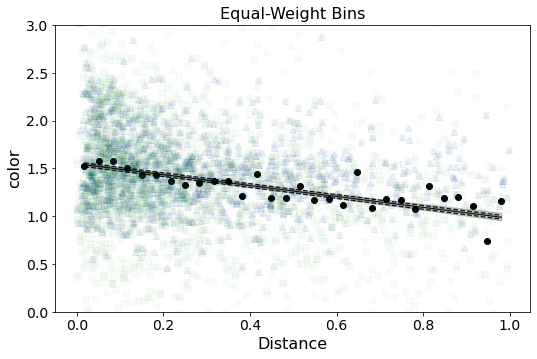

In [474]:
#plotting code based off of Hailey's notebook

from matplotlib.patches import Ellipse

#nbins = len(dist)

sigmas = hf.get_sigmas()

#xvals = np.linspace(0, 1, nbins)
xvals = dist

yvals = hf.coords[0] * xvals + hf.coords[1]
#yvals = hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
data = data #[log10vmax[isrmeas], rmag[isrmeas]]

#x_err = np.full(3505, (1/nbins)) #np.ones(3505) #dlog10vmax[isrmeas]
#x_err = np.full(3080, (1/nbins)) #when masking values above 1 Mpc/h
x_err = dist_err

#y_err = du_r #drmag[isrmeas]
y_err = u_r_err
corr_xy = np.zeros_like(x_err)

# Generate ellipses
# ells = [
#     Ellipse(
#         #xy=[data[0][i], data[1][i]],
#         xy=[xvals[i], yvals[i]],
#         width=2.0 * y_err[i],
#         height=2.0 * x_err[i],
#         angle=np.rad2deg(np.arccos(corr_xy[i])),
#     )
#     #for i in range(len(data[0]))
#     for i in range(len(xvals))
# ]    
       
    
# Make the plot
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
# for i, e in enumerate(ells):
#     ax.add_artist(e)
#     #e.set_color(cmocean.cm.thermal(sigmas[i] / np.amax(sigmas)))
#     e.set_edgecolor('None')
#     e.set_alpha(0.9)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)
#ax.set_title(r"Coma", fontsize = 16)
# ax.set_xlim(0, 3)
# ax.set_ylim(-0., 3)

ax.scatter(data[0], data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

ax.set_ylim(0., 3)
#ax.set_ylim(1, 1.8)

ax.set_title('Equal-Weight Bins', fontsize = 16)

### with new color error table

Text(0.5, 1.0, 'Equal-Weight Bins')

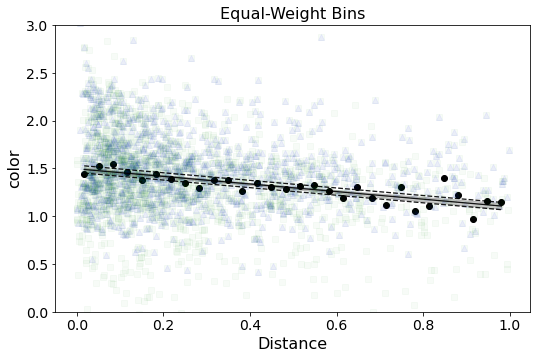

In [58]:
#plotting code based off of Hailey's notebook

from matplotlib.patches import Ellipse

#nbins = len(dist)

sigmas = hf.get_sigmas()

#xvals = np.linspace(0, 1, nbins)
xvals = dist

yvals = hf.coords[0] * xvals + hf.coords[1]
#yvals = hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
data = data #[log10vmax[isrmeas], rmag[isrmeas]]

#x_err = np.full(3505, (1/nbins)) #np.ones(3505) #dlog10vmax[isrmeas]
#x_err = np.full(3080, (1/nbins)) #when masking values above 1 Mpc/h
x_err = dist_err

#y_err = du_r #drmag[isrmeas]
y_err = u_r_err
corr_xy = np.zeros_like(x_err)

# Generate ellipses
# ells = [
#     Ellipse(
#         #xy=[data[0][i], data[1][i]],
#         xy=[xvals[i], yvals[i]],
#         width=2.0 * y_err[i],
#         height=2.0 * x_err[i],
#         angle=np.rad2deg(np.arccos(corr_xy[i])),
#     )
#     #for i in range(len(data[0]))
#     for i in range(len(xvals))
# ]    
       
    
# Make the plot
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
# for i, e in enumerate(ells):
#     ax.add_artist(e)
#     #e.set_color(cmocean.cm.thermal(sigmas[i] / np.amax(sigmas)))
#     e.set_edgecolor('None')
#     e.set_alpha(0.9)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)
#ax.set_title(r"Coma", fontsize = 16)
# ax.set_xlim(0, 3)
# ax.set_ylim(-0., 3)

ax.scatter(data[0], data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

ax.set_ylim(0., 3)
#ax.set_ylim(1, 1.8)

ax.set_title('Equal-Weight Bins', fontsize = 16)

Text(0.5, 1.0, 'Cleaned, Equal-Weight Bins')

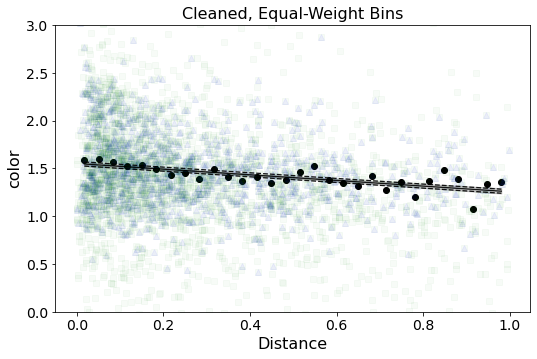

In [418]:
#plotting code based off of Hailey's notebook

from matplotlib.patches import Ellipse

#nbins = len(dist)

sigmas = hf.get_sigmas()

#xvals = np.linspace(0, 1, nbins)
xvals = dist

yvals = hf.coords[0] * xvals + hf.coords[1]
#yvals = hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
data = data #[log10vmax[isrmeas], rmag[isrmeas]]

#x_err = np.full(3505, (1/nbins)) #np.ones(3505) #dlog10vmax[isrmeas]
#x_err = np.full(3080, (1/nbins)) #when masking values above 1 Mpc/h
x_err = dist_err

#y_err = du_r #drmag[isrmeas]
y_err = u_r_err
corr_xy = np.zeros_like(x_err)

# Generate ellipses
# ells = [
#     Ellipse(
#         #xy=[data[0][i], data[1][i]],
#         xy=[xvals[i], yvals[i]],
#         width=2.0 * y_err[i],
#         height=2.0 * x_err[i],
#         angle=np.rad2deg(np.arccos(corr_xy[i])),
#     )
#     #for i in range(len(data[0]))
#     for i in range(len(xvals))
# ]    
       
    
# Make the plot
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
# for i, e in enumerate(ells):
#     ax.add_artist(e)
#     #e.set_color(cmocean.cm.thermal(sigmas[i] / np.amax(sigmas)))
#     e.set_edgecolor('None')
#     e.set_alpha(0.9)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)
#ax.set_title(r"Coma", fontsize = 16)
# ax.set_xlim(0, 3)
# ax.set_ylim(-0., 3)

ax.scatter(data[0], data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

ax.set_ylim(0., 3)
#ax.set_ylim(1, 1.8)

ax.set_title('Equal-Weight Bins', fontsize = 16)

Text(0.5, 1.0, 'Equal-Weight Bins')

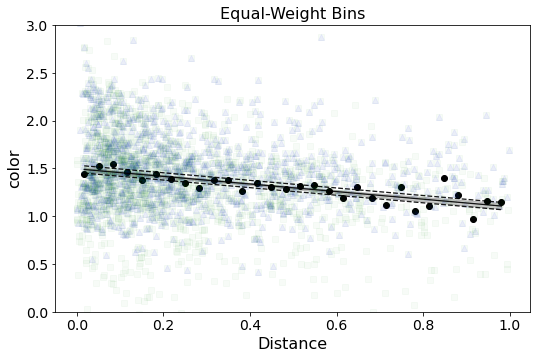

In [59]:
#plotting code based off of Hailey's notebook

from matplotlib.patches import Ellipse

#nbins = len(dist)

sigmas = hf.get_sigmas()

#xvals = np.linspace(0, 1, nbins)
xvals = dist

yvals = hf.coords[0] * xvals + hf.coords[1]
#yvals = hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
data = data #[log10vmax[isrmeas], rmag[isrmeas]]

#x_err = np.full(3505, (1/nbins)) #np.ones(3505) #dlog10vmax[isrmeas]
#x_err = np.full(3080, (1/nbins)) #when masking values above 1 Mpc/h
x_err = dist_err

#y_err = du_r #drmag[isrmeas]
y_err = u_r_err
corr_xy = np.zeros_like(x_err)

# Generate ellipses
# ells = [
#     Ellipse(
#         #xy=[data[0][i], data[1][i]],
#         xy=[xvals[i], yvals[i]],
#         width=2.0 * y_err[i],
#         height=2.0 * x_err[i],
#         angle=np.rad2deg(np.arccos(corr_xy[i])),
#     )
#     #for i in range(len(data[0]))
#     for i in range(len(xvals))
# ]    
       
    
# Make the plot
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
# for i, e in enumerate(ells):
#     ax.add_artist(e)
#     #e.set_color(cmocean.cm.thermal(sigmas[i] / np.amax(sigmas)))
#     e.set_edgecolor('None')
#     e.set_alpha(0.9)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)
#ax.set_title(r"Coma", fontsize = 16)
# ax.set_xlim(0, 3)
# ax.set_ylim(-0., 3)

ax.scatter(data[0], data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

ax.set_ylim(0., 3)
#ax.set_ylim(1, 1.8)

ax.set_title('Equal-Weight Bins', fontsize = 16)

## Ploting profile Hist Hyperfit plots side by side

Text(0.5, 1.0, 'Weighted Bins ($w_i=1/\\sigma_i^2$)')

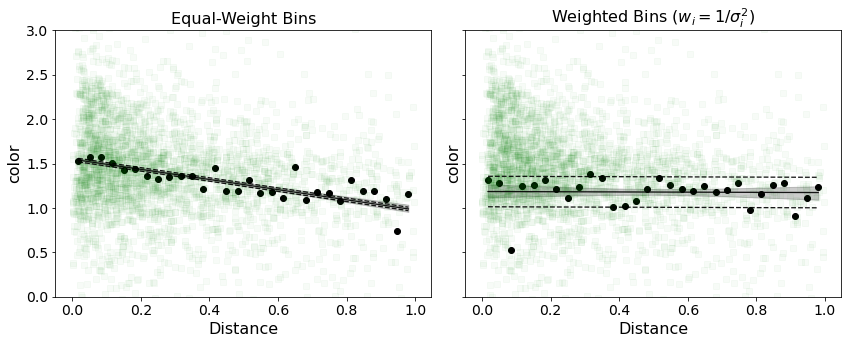

In [475]:
from matplotlib.patches import Ellipse

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]

sigmas = hf.get_sigmas()
xvals = dist
yvals = hf.coords[0] * xvals + hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
data = data 
x_err = dist_err
y_err = u_r_err
corr_xy = np.zeros_like(x_err)

# Make the plot
#fig = plt.figure(figsize=(6.4,4.8))
#ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)


ax.scatter(data[0], data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

#ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

#ax.set_ylim(0., 3)
ax.set_ylim(1, 1.8)

ax.set_title('Equal-Weight Bins', fontsize = 16)


ax = axes[1]

w_sigmas = w_hf.get_sigmas()
w_xvals = w_dist
w_yvals = w_hf.coords[0] * w_xvals + w_hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
w_y_chain = np.outer(w_xvals, w_mcmc_samples[0]) + w_mcmc_samples[1]
w_y_chain_quantiles = np.quantile(w_y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
w_data = w_data 
w_x_err = w_dist_err
w_y_err = w_u_r_err
w_corr_xy = np.zeros_like(w_x_err)

# Make the plot
#fig = plt.figure(figsize=(6.4,4.8))
#ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

ax.fill_between(w_xvals, w_y_chain_quantiles[0], w_y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(w_xvals, w_yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(w_xvals, w_yvals - w_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(w_xvals, w_yvals + w_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)


ax.scatter(w_data[0], w_data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

#ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

ax.set_ylim(0., 3)
#ax.set_ylim(0.5, 1.8)

ax.set_title('Weighted Bins ($w_i=1/\sigma_i^2$)', fontsize = 16)

Text(0.5, 1.0, 'Weighted Bins ($w_i=1/\\sigma_i^2$)')

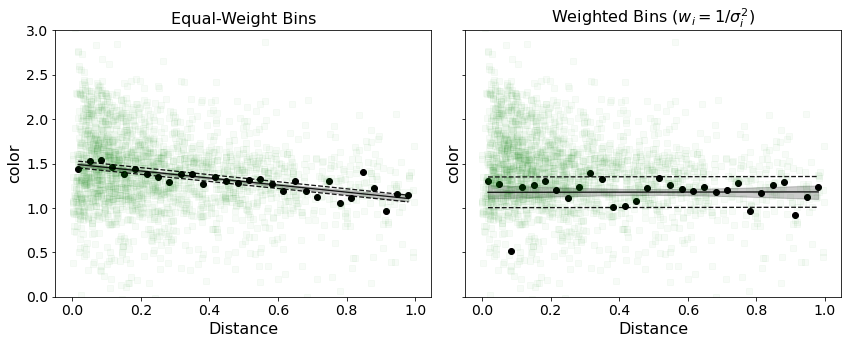

In [60]:
from matplotlib.patches import Ellipse

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]

sigmas = hf.get_sigmas()
xvals = dist
yvals = hf.coords[0] * xvals + hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
data = data 
x_err = dist_err
y_err = u_r_err
corr_xy = np.zeros_like(x_err)

# Make the plot
#fig = plt.figure(figsize=(6.4,4.8))
#ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)


ax.scatter(data[0], data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

#ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

#ax.set_ylim(0., 3)
ax.set_ylim(1, 1.8)

ax.set_title('Equal-Weight Bins', fontsize = 16)


ax = axes[1]

w_sigmas = w_hf.get_sigmas()
w_xvals = w_dist
w_yvals = w_hf.coords[0] * w_xvals + w_hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
w_y_chain = np.outer(w_xvals, w_mcmc_samples[0]) + w_mcmc_samples[1]
w_y_chain_quantiles = np.quantile(w_y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
w_data = w_data 
w_x_err = w_dist_err
w_y_err = w_u_r_err
w_corr_xy = np.zeros_like(w_x_err)

# Make the plot
#fig = plt.figure(figsize=(6.4,4.8))
#ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

ax.fill_between(w_xvals, w_y_chain_quantiles[0], w_y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(w_xvals, w_yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(w_xvals, w_yvals - w_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(w_xvals, w_yvals + w_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)


ax.scatter(w_data[0], w_data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

#ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

ax.set_ylim(0., 3)
#ax.set_ylim(0.5, 1.8)

ax.set_title('Weighted Bins ($w_i=1/\sigma_i^2$)', fontsize = 16)

Text(0.5, 1.0, 'Cleaned, Weighted Bins ($w_i=1/\\sigma_i^2$)')

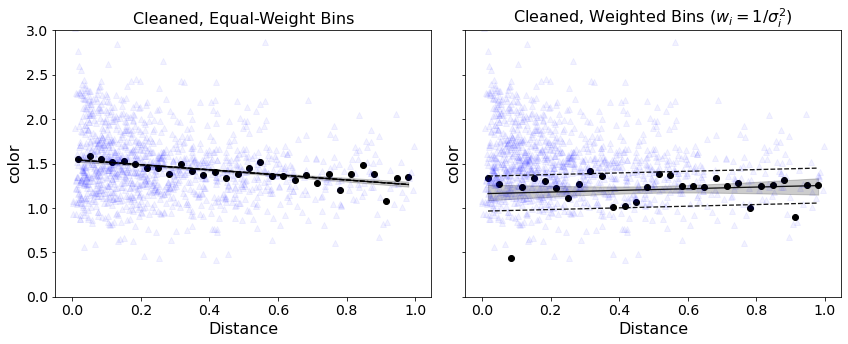

In [61]:
from matplotlib.patches import Ellipse

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]

c_sigmas = c_hf.get_sigmas()
c_xvals = c_dist
c_yvals = c_hf.coords[0] * c_xvals + c_hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
c_y_chain = np.outer(c_xvals, c_mcmc_samples[0]) + c_mcmc_samples[1]
c_y_chain_quantiles = np.quantile(c_y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
c_data = c_data 
c_x_err = c_dist_err
c_y_err = c_u_r_err
c_corr_xy = np.zeros_like(c_x_err)

# Make the plot
#fig = plt.figure(figsize=(6.4,4.8))
#ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

ax.fill_between(c_xvals, c_y_chain_quantiles[0], c_y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(c_xvals, c_yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(c_xvals, c_yvals - c_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(c_xvals, c_yvals + c_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)


ax.scatter(c_data[0], c_data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

#ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

#ax.set_ylim(0., 3)
ax.set_ylim(1, 1.8)

ax.set_title('Cleaned, Equal-Weight Bins', fontsize = 16)


ax = axes[1]

cw_sigmas = cw_hf.get_sigmas()
cw_xvals = cw_dist
cw_yvals = cw_hf.coords[0] * cw_xvals + cw_hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
cw_y_chain = np.outer(cw_xvals, cw_mcmc_samples[0]) + cw_mcmc_samples[1]
cw_y_chain_quantiles = np.quantile(cw_y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
cw_data = cw_data 
cw_x_err = cw_dist_err
cw_y_err = cw_u_r_err
cw_corr_xy = np.zeros_like(cw_x_err)

# Make the plot
#fig = plt.figure(figsize=(6.4,4.8))
#ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

ax.fill_between(cw_xvals, cw_y_chain_quantiles[0], cw_y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(cw_xvals, cw_yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(cw_xvals, cw_yvals - cw_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(cw_xvals, cw_yvals + cw_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)


ax.scatter(cw_data[0], cw_data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

#ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

ax.set_ylim(0., 3)
#ax.set_ylim(0.5, 1.8)

ax.set_title('Cleaned, Weighted Bins ($w_i=1/\sigma_i^2$)', fontsize = 16)

# Looking into linregress

slopes: -0.3133553028233604 -0.2737574674675049 -0.007896960624011861


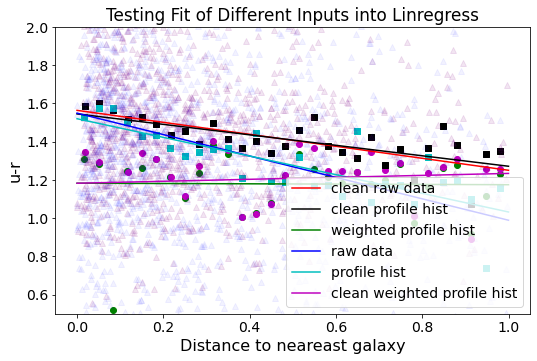

In [560]:
result1 = stats.linregress(neigh_dist2d_clean, u_r_clean)
result2 = stats.linregress(c_data[0], c_data[1]) 
result3 = stats.linregress(w_data[0], w_data[1])
result4 = stats.linregress(neigh_dist2d, u_r)
result5 = stats.linregress(data[0], data[1])
result6 = stats.linregress(cw_data[0], cw_data[1])
#fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

#ax = axes[0]

fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

x = np.linspace(0,1,31)
#x_raw = neigh_dist2d_clean
y = result1.slope*x+result1.intercept
#y_raw = result1.slope*x_raw+result1.intercept
ax.plot(x, y, '-r', label = 'clean raw data') #, label='y=2x+1')
#ax.plot(x_raw, y_raw, '-b', label = 'clean raw raw data') 
y2 = result2.slope*x+result2.intercept
ax.plot(x, y2, '-k', label = 'clean profile hist')
y3 = result3.slope*x+result3.intercept
ax.plot(x, y3, '-g', label = 'weighted profile hist') 
y4 = result4.slope*x+result4.intercept
ax.plot(x, y4, '-b', label = 'raw data')
y5 = result5.slope*x+result5.intercept
ax.plot(x, y5, '-c', label = 'profile hist')
y6 = result6.slope*x+result6.intercept
ax.plot(x, y6, '-m', label = 'clean weighted profile hist')
 
ax.scatter(w_data[0], w_data[1], alpha=1, color='g', marker='o') #plotting profile Hist binned points
ax.scatter(cw_data[0], cw_data[1], alpha=1, color='m', marker='o') #plotting profile Hist binned points
ax.scatter(c_data[0], c_data[1], alpha=1, color='k', marker='s') #plotting profile Hist binned points
ax.scatter(data[0], data[1], alpha=1, color='c', marker='s') #plotting profile Hist binned points
ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'r', marker = '^') #plotting full cleaned data    
ax.scatter(neigh_dist2d, u_r, alpha = 0.05, color = 'b', marker = '^')
#ax = axes[1]
ax.set_ylim(0.5, 2)
ax.set_xlabel('Distance to neareast galaxy', fontsize=16)
ax.set_ylabel('u-r', fontsize=16)
ax.set_title('Testing Fit of Different Inputs into Linregress')
ax.legend()
print('slopes:', result1.slope, result2.slope, result3.slope)

slopes: -0.29546787447460454 -0.26421158915470794 0.00346197376361479


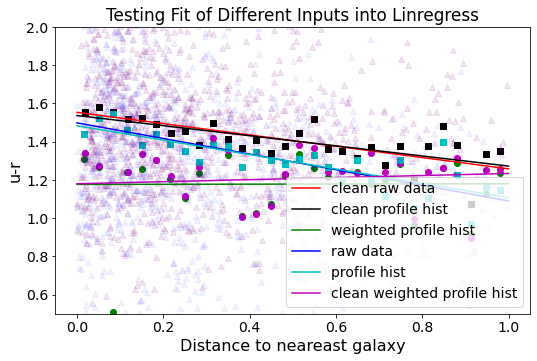

In [62]:
result1 = stats.linregress(neigh_dist2d_clean, u_r_clean)
result2 = stats.linregress(c_data[0], c_data[1]) 
result3 = stats.linregress(w_data[0], w_data[1])
result4 = stats.linregress(neigh_dist2d, u_r)
result5 = stats.linregress(data[0], data[1])
result6 = stats.linregress(cw_data[0], cw_data[1])
#fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

#ax = axes[0]

fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

x = np.linspace(0,1,31)
#x_raw = neigh_dist2d_clean
y = result1.slope*x+result1.intercept
#y_raw = result1.slope*x_raw+result1.intercept
ax.plot(x, y, '-r', label = 'clean raw data') #, label='y=2x+1')
#ax.plot(x_raw, y_raw, '-b', label = 'clean raw raw data') 
y2 = result2.slope*x+result2.intercept
ax.plot(x, y2, '-k', label = 'clean profile hist')
y3 = result3.slope*x+result3.intercept
ax.plot(x, y3, '-g', label = 'weighted profile hist') 
y4 = result4.slope*x+result4.intercept
ax.plot(x, y4, '-b', label = 'raw data')
y5 = result5.slope*x+result5.intercept
ax.plot(x, y5, '-c', label = 'profile hist')
y6 = result6.slope*x+result6.intercept
ax.plot(x, y6, '-m', label = 'clean weighted profile hist')
 
ax.scatter(w_data[0], w_data[1], alpha=1, color='g', marker='o') #plotting profile Hist binned points
ax.scatter(cw_data[0], cw_data[1], alpha=1, color='m', marker='o') #plotting profile Hist binned points
ax.scatter(c_data[0], c_data[1], alpha=1, color='k', marker='s') #plotting profile Hist binned points
ax.scatter(data[0], data[1], alpha=1, color='c', marker='s') #plotting profile Hist binned points
ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'r', marker = '^') #plotting full cleaned data    
ax.scatter(neigh_dist2d, u_r, alpha = 0.05, color = 'b', marker = '^')
#ax = axes[1]
ax.set_ylim(0.5, 2)
ax.set_xlabel('Distance to neareast galaxy', fontsize=16)
ax.set_ylabel('u-r', fontsize=16)
ax.set_title('Testing Fit of Different Inputs into Linregress')
ax.legend()
print('slopes:', result1.slope, result2.slope, result3.slope)

# Plotting wall galaxies sSFR with weighted histogram for fit

In [63]:
neigh_dist2d = dwarf_table[dwarf_wall]['2D_neighbor_dist'].value
sSFR  = dwarf_table[dwarf_wall]['sSFR'].value
dsSFR = dwarf_table[dwarf_wall]['sSFR_err'].value

#doing void dwarfs instead
#neigh_dist2d = dwarf_table[dwarf_void]['2D_neighbor_dist'].value
#sSFR  = dwarf_table[dwarf_void]['sSFR'].value
#dsSFR = dwarf_table[dwarf_void]['sSFR_err'].value

# Cut out the NaNs from the dwarf table.
select = ~np.isnan(sSFR) & ~np.isnan(dsSFR) & (neigh_dist2d <= 1.)

neigh_dist2d = neigh_dist2d[select]
sSFR  = sSFR[select]
dsSFR = dsSFR[select]

In [64]:
w_dist, w_sSFR_avg, w_sSFR_err = profilehist(neigh_dist2d, sSFR, w=1./dsSFR**2, bins=30, uncertainty='stderr')

w_dist_err = 0.5*np.diff(dist)[0]

In [65]:
w_ndata = len(w_sSFR_avg)
w_cov = np.empty((2, 2, ndata))
w_data = np.empty((2, ndata))

# Pack data into 2xN array and covariances into 2x2xN array.
for i, (_dist, _sSFR, _dsSFR) in enumerate(zip(w_dist, w_sSFR_avg, w_sSFR_err)):        
    w_data[0,i] = _dist
    w_data[1,i] = _sSFR
    w_cov[:,:,i] = np.array([[0., 0.], [0., _dsSFR**2]])

In [66]:
w_hf = LinFit(w_data, w_cov)
print(w_hf)

In [67]:
w_bounds = ((-10,10), (-20,10), (1e-5,5))
# bounds = ((-0.1,0.1), (-1,2), (1e-5,5))
w_result = w_hf.optimize(w_bounds, verbose=True)
w_result

     fun: array([-48.69517814])
     jac: array([0.00165556, 0.00140901, 0.00047038])
 message: 'Optimization terminated successfully.'
    nfev: 3346
     nit: 73
 success: True
       x: array([ 2.67213072, -8.94665694,  0.10794084])


(array([ 0.29867365, -9.74475199]), 0.11765197396645954, 48.695178139826346)

In [68]:
w_mcmc_samples, w_mcmc_lnlike = w_hf.emcee(w_bounds, verbose=True)
print(np.mean(w_mcmc_samples, axis=1), np.std(w_mcmc_samples, axis=1))

     fun: array([-48.69517577])
     jac: array([-0.00131521, -0.00488356, -0.00269083])
 message: 'Optimization terminated successfully.'
    nfev: 3080
     nit: 67
 success: True
       x: array([ 2.66937942, -8.94827308,  0.10793394])


100%|██████████| 1000/1000 [00:00<00:00, 1248.42it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [83.94898563 83.85932066 33.79584338] / 4197.449281607278


100%|██████████| 1000/1000 [00:00<00:00, 1239.41it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [103.9271136  103.54489338  51.99936912] / 5196.355679987697


100%|██████████| 1000/1000 [00:00<00:00, 1239.76it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [120.16650157 125.91976992  72.1953796 ] / 6295.988496114165


100%|██████████| 1000/1000 [00:00<00:00, 1239.79it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [122.92870997 117.95640158  63.80098266] / 6146.435498490028


100%|██████████| 1000/1000 [00:00<00:00, 1228.32it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [109.01391173 106.80052918  52.64261218] / 5450.695586379154


100%|██████████| 1000/1000 [00:00<00:00, 1197.09it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [138.46705625 137.48874817  69.18334757] / 6923.352812705354


100%|██████████| 1000/1000 [00:00<00:00, 1187.45it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [144.76015816 144.45738809  67.27736092] / 7238.0079081563235


100%|██████████| 1000/1000 [00:00<00:00, 1212.39it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [164.48978139 165.63985412  71.37606228] / 8281.992705895127


100%|██████████| 1000/1000 [00:00<00:00, 1230.99it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [173.31765805 171.2556157   76.91064153] / 8665.882902570644


100%|██████████| 1000/1000 [00:00<00:00, 1203.79it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [190.07166817 189.2694817   82.28858345] / 9503.583408631835


100%|██████████| 1000/1000 [00:00<00:00, 1191.39it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [183.43208031 186.40080697  76.33514363] / 9320.040348306744


100%|██████████| 1000/1000 [00:00<00:00, 1215.60it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [199.33324749 203.15270419  73.89945834] / 10157.635209329404


100%|██████████| 1000/1000 [00:00<00:00, 1229.34it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [224.43190216 225.68428356  71.29629091] / 11284.214178193564


100%|██████████| 1000/1000 [00:00<00:00, 1164.75it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [250.02868755 243.64059892  76.72398613] / 12501.434377277146


100%|██████████| 1000/1000 [00:00<00:00, 1160.33it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [252.12494424 240.04250315  74.46598713] / 12606.247211889095
[ 0.30076542 -9.7450609   0.12425377] [0.09631262 0.05218998 0.02179495]


In [600]:
w_mcmc_samples, w_mcmc_lnlike = w_hf.emcee(w_bounds, verbose=True)
print(np.mean(w_mcmc_samples, axis=1), np.std(w_mcmc_samples, axis=1))

     fun: array([-45.08174287])
     jac: array([-0.00082991, -0.00098765, -0.00175717])
 message: 'Optimization terminated successfully.'
    nfev: 2851
     nit: 62
 success: True
       x: array([ 1.95110981, -9.18078952,  0.12285316])


100%|██████████| 1000/1000 [00:00<00:00, 1143.89it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [90.24139838 88.70135027 45.16839933] / 4512.069918921189


100%|██████████| 1000/1000 [00:00<00:00, 1071.80it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [103.91940051 104.99326223  48.97862455] / 5249.663111466829


100%|██████████| 1000/1000 [00:00<00:00, 1081.61it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [128.15342859 117.35607117  71.987439  ] / 6407.671429735102


100%|██████████| 1000/1000 [00:00<00:00, 1067.19it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [144.10985839 125.15802359  73.66994815] / 7205.4929193290245


100%|██████████| 1000/1000 [00:00<00:00, 1044.74it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [138.56975039 135.49075791  69.4573604 ] / 6928.48751938617


100%|██████████| 1000/1000 [00:00<00:00, 1060.72it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [141.55464062 147.32258544  60.12919576] / 7366.1292719365765


100%|██████████| 1000/1000 [00:00<00:00, 1066.34it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [143.74047007 137.75500622  59.1012748 ] / 7187.023503292976


100%|██████████| 1000/1000 [00:01<00:00, 942.10it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [161.77477447 162.10840517  59.74966009] / 8105.420258395733


100%|██████████| 1000/1000 [00:00<00:00, 1136.88it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [200.70669479 194.71520634  63.53387056] / 10035.334739711769


100%|██████████| 1000/1000 [00:00<00:00, 1160.91it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [209.74139657 191.29493283  64.50392721] / 10487.06982851676


100%|██████████| 1000/1000 [00:00<00:00, 1178.99it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [235.73167178 219.84402195  77.98030068] / 11786.583589117783


100%|██████████| 1000/1000 [00:00<00:00, 1182.00it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [248.77995102 238.7857742   74.29187275] / 12438.997550911623


100%|██████████| 1000/1000 [00:00<00:00, 1155.16it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [221.72513837 204.26790209  73.40636142] / 11086.256918599269


100%|██████████| 1000/1000 [00:00<00:00, 1171.72it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [230.41655958 220.95339851  78.20306225] / 11520.827978871826


100%|██████████| 1000/1000 [00:00<00:00, 1180.09it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [238.47232742 227.35045808  81.57019746] / 11923.616370943644
[ 0.21441846 -9.59628975  0.13967773] [0.10447928 0.05719217 0.02372707]


In [69]:
# w_a = slope, w_b = intercept, w_sig = error on intercept

w_a, w_b, w_sig    = np.mean(w_mcmc_samples, axis=1)
w_da, w_db, w_dsig = np.std(w_mcmc_samples, axis=1)
w_labels = ['w_a', 'w_b', 'w_sigma']

for w_label, w_val, w_err in zip(w_labels, (w_a, w_b, w_sig), (w_da, w_db, w_dsig)):
    print('{:6s}= {:6.3f} +/- {:.3f}'.format(w_label, w_val, w_err))

w_a   =  0.301 +/- 0.096
w_b   = -9.745 +/- 0.052
w_sigma=  0.124 +/- 0.022


In [601]:
# w_a = slope, w_b = intercept, w_sig = error on intercept

w_a, w_b, w_sig    = np.mean(w_mcmc_samples, axis=1)
w_da, w_db, w_dsig = np.std(w_mcmc_samples, axis=1)
w_labels = ['w_a', 'w_b', 'w_sigma']

for w_label, w_val, w_err in zip(w_labels, (w_a, w_b, w_sig), (w_da, w_db, w_dsig)):
    print('{:6s}= {:6.3f} +/- {:.3f}'.format(w_label, w_val, w_err))

w_a   =  0.214 +/- 0.104
w_b   = -9.596 +/- 0.057
w_sigma=  0.140 +/- 0.024


In [70]:
from corner import corner

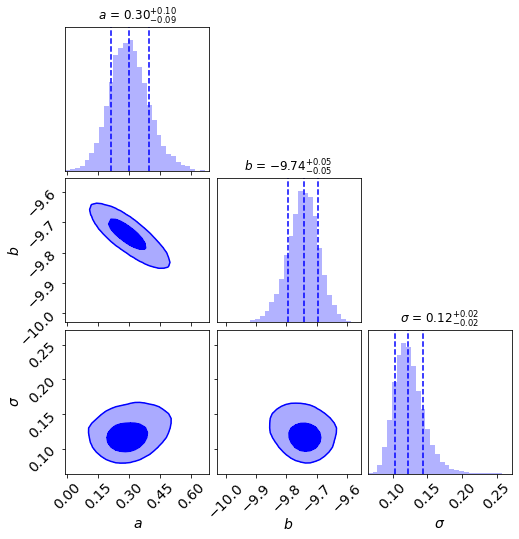

In [71]:
fig = corner(w_mcmc_samples.T, bins=30, smooth=1,
             # range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})

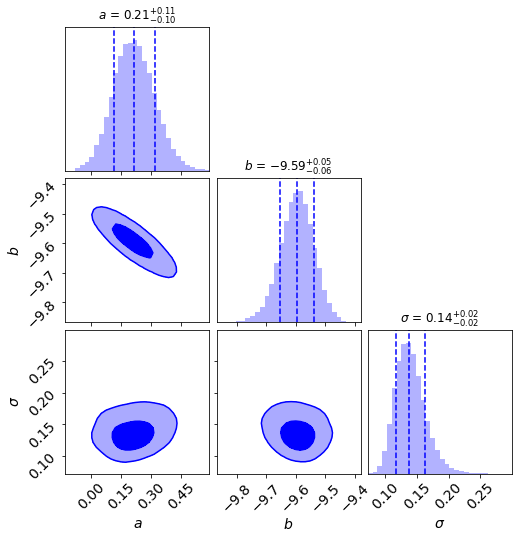

In [602]:
fig = corner(w_mcmc_samples.T, bins=30, smooth=1,
             # range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})

need only the weighted one, make only one plot, not 2 figures

In [ ]:
from matplotlib.patches import Ellipse

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]

sigmas = hf.get_sigmas()
xvals = dist
yvals = hf.coords[0] * xvals + hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
data = data 
x_err = dist_err
y_err = sSFR_err
corr_xy = np.zeros_like(x_err)

# Make the plot
#fig = plt.figure(figsize=(6.4,4.8))
#ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)


ax.scatter(data[0], data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

#ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

#ax.set_ylim(0., 3)
ax.set_ylim(1, 1.8)

ax.set_title('Equal-Weight Bins', fontsize = 16)


ax = axes[1]

w_sigmas = w_hf.get_sigmas()
w_xvals = w_dist
w_yvals = w_hf.coords[0] * w_xvals + w_hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
w_y_chain = np.outer(w_xvals, w_mcmc_samples[0]) + w_mcmc_samples[1]
w_y_chain_quantiles = np.quantile(w_y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
w_data = w_data 
w_x_err = w_dist_err
w_y_err = w_u_r_err
w_corr_xy = np.zeros_like(w_x_err)

# Make the plot
#fig = plt.figure(figsize=(6.4,4.8))
#ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

ax.fill_between(w_xvals, w_y_chain_quantiles[0], w_y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(w_xvals, w_yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(w_xvals, w_yvals - w_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(w_xvals, w_yvals + w_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('color', fontsize=16)


ax.scatter(w_data[0], w_data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

#ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, u_r, alpha = 0.03, color = 'g', marker = 's') #plotting full data

ax.set_ylim(0., 3)
#ax.set_ylim(0.5, 1.8)

ax.set_title('Weighted Bins ($w_i=1/\sigma_i^2$)', fontsize = 16)

Text(0.5, 1.0, 'Wall Dwarfs sSFR Weighted Bins')

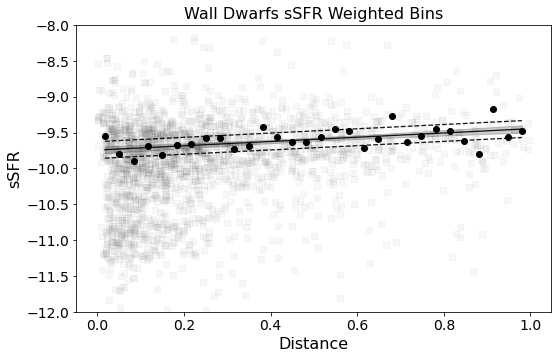

In [72]:
#plotting code based off of Hailey's notebook

from matplotlib.patches import Ellipse

#nbins = len(dist)

w_sigmas = w_hf.get_sigmas()

#xvals = np.linspace(0, 1, nbins)
w_xvals = w_dist

w_yvals = w_hf.coords[0] * w_xvals + w_hf.coords[1]
#yvals = hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
w_y_chain = np.outer(w_xvals, w_mcmc_samples[0]) + w_mcmc_samples[1]
w_y_chain_quantiles = np.quantile(w_y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
w_data = w_data #[log10vmax[isrmeas], rmag[isrmeas]]

#x_err = np.full(3505, (1/nbins)) #np.ones(3505) #dlog10vmax[isrmeas]
#x_err = np.full(3080, (1/nbins)) #when masking values above 1 Mpc/h
w_x_err = w_dist_err

#y_err = du_r #drmag[isrmeas]
w_y_err = w_sSFR_err
w_corr_xy = np.zeros_like(w_x_err)
     
    
# Make the plot
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

ax.fill_between(w_xvals, w_y_chain_quantiles[0], w_y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(w_xvals, w_yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(w_xvals, w_yvals - w_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(w_xvals, w_yvals + w_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('sSFR', fontsize=16)

# ax.set_xlim(0, 3)
# ax.set_ylim(-0., 3)

ax.scatter(w_data[0], w_data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

#ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, sSFR, alpha = 0.03, color = 'k', marker = 's') #plotting full data

#ax.set_ylim(0., 3)
ax.set_ylim(-12, -8)

ax.set_title('Wall Dwarfs sSFR Weighted Bins', fontsize = 16)

Text(0.5, 1.0, 'Wall Dwarfs sSFR Weighted Bins')

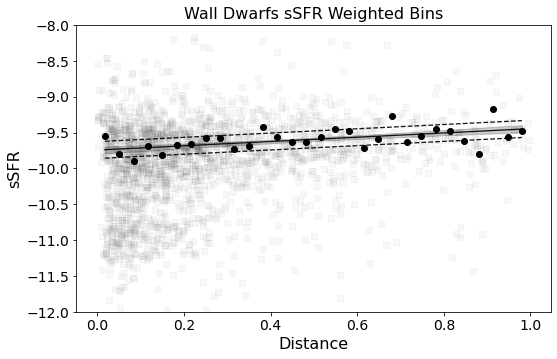

In [594]:
#plotting code based off of Hailey's notebook

from matplotlib.patches import Ellipse

#nbins = len(dist)

w_sigmas = w_hf.get_sigmas()

#xvals = np.linspace(0, 1, nbins)
w_xvals = w_dist

w_yvals = w_hf.coords[0] * w_xvals + w_hf.coords[1]
#yvals = hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
w_y_chain = np.outer(w_xvals, w_mcmc_samples[0]) + w_mcmc_samples[1]
w_y_chain_quantiles = np.quantile(w_y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
w_data = w_data #[log10vmax[isrmeas], rmag[isrmeas]]

#x_err = np.full(3505, (1/nbins)) #np.ones(3505) #dlog10vmax[isrmeas]
#x_err = np.full(3080, (1/nbins)) #when masking values above 1 Mpc/h
w_x_err = w_dist_err

#y_err = du_r #drmag[isrmeas]
w_y_err = w_sSFR_err
w_corr_xy = np.zeros_like(w_x_err)
     
    
# Make the plot
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

ax.fill_between(w_xvals, w_y_chain_quantiles[0], w_y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(w_xvals, w_yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(w_xvals, w_yvals - w_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(w_xvals, w_yvals + w_hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('sSFR', fontsize=16)

# ax.set_xlim(0, 3)
# ax.set_ylim(-0., 3)

ax.scatter(w_data[0], w_data[1], alpha=1, color='k', marker='o') #plotting profile Hist binned points

#ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, sSFR, alpha = 0.03, color = 'k', marker = 's') #plotting full data

#ax.set_ylim(0., 3)
ax.set_ylim(-12, -8)

ax.set_title('Wall Dwarfs sSFR Weighted Bins', fontsize = 16)

Text(0.5, 1.0, 'Void Dwarfs sSFR Weighted Bins')

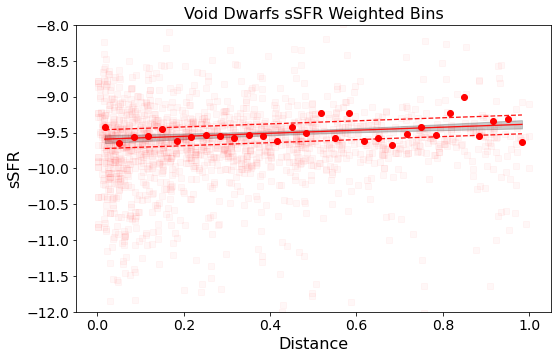

In [603]:
from matplotlib.patches import Ellipse

#nbins = len(dist)

w_sigmas = w_hf.get_sigmas()

#xvals = np.linspace(0, 1, nbins)
w_xvals = w_dist

w_yvals = w_hf.coords[0] * w_xvals + w_hf.coords[1]
#yvals = hf.coords[1]


# Get the MCMC 1-sigma quantiles to plot with the fit.
w_y_chain = np.outer(w_xvals, w_mcmc_samples[0]) + w_mcmc_samples[1]
w_y_chain_quantiles = np.quantile(w_y_chain, [0.1587, 0.8414], axis=1)


# Pack info into data
w_data = w_data #[log10vmax[isrmeas], rmag[isrmeas]]

#x_err = np.full(3505, (1/nbins)) #np.ones(3505) #dlog10vmax[isrmeas]
#x_err = np.full(3080, (1/nbins)) #when masking values above 1 Mpc/h
w_x_err = w_dist_err

#y_err = du_r #drmag[isrmeas]
w_y_err = w_sSFR_err
w_corr_xy = np.zeros_like(w_x_err)
     
    
# Make the plot
fig = plt.figure(figsize=(6.4,4.8))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])

ax.fill_between(w_xvals, w_y_chain_quantiles[0], w_y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(w_xvals, w_yvals, c="r", marker="None", ls="-", lw=1.3, alpha=0.9)                     #solid line of best fit
ax.plot(w_xvals, w_yvals - w_hf.vert_scat, c="r", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 1
ax.plot(w_xvals, w_yvals + w_hf.vert_scat, c="r", marker="None", ls="--", lw=1.3, alpha=0.9)     # dashed line 2
ax.set_xlabel('Distance', fontsize=16)
ax.set_ylabel('sSFR', fontsize=16)

# ax.set_xlim(0, 3)
# ax.set_ylim(-0., 3)

ax.scatter(w_data[0], w_data[1], alpha=1, color='r', marker='o') #plotting profile Hist binned points

#ax.scatter(neigh_dist2d_clean, u_r_clean, alpha = 0.05, color = 'b', marker = '^') #plotting full cleaned data

ax.scatter(neigh_dist2d, sSFR, alpha = 0.03, color = 'r', marker = 's') #plotting full data

#ax.set_ylim(0., 3)
ax.set_ylim(-12, -8)

ax.set_title('Void Dwarfs sSFR Weighted Bins', fontsize = 16)

# Finding best method to get most accurate fit
### Using Simulated data with a known linear relationship to see which fit matches the best

In [552]:
dy = np.random.random_sample(len(y))

"\n#histograms\n\nax = axes[1,0]\nax.hist(x)\nax.set(xlabel='$x$', ylabel='count', title='Histogram of $x$ values')\n\nax = axes[1,1]\nax.hist(y)\nax.set(xlabel='$y$', ylabel='count', title='Histogram of $y$ values')\n"

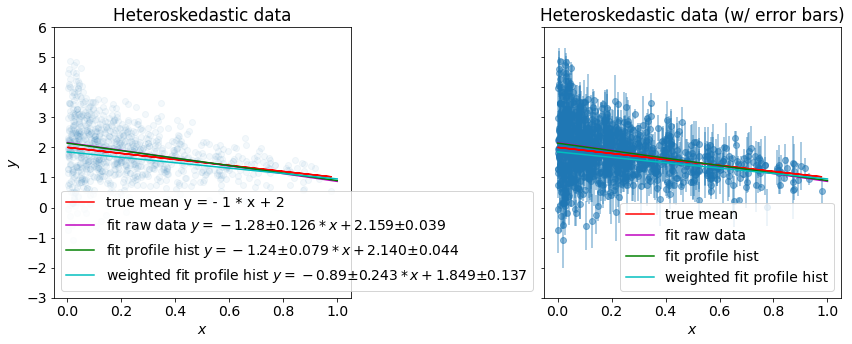

In [553]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.RandomState(42)
x = rng.exponential(scale=0.25, size=1000)
x = x[x <= 1]
y_true_mean = 2 - 1 * x
y = y_true_mean + rng.normal(loc=0, scale=0.2 + 0.2*(x+0.1)**-0.75, size=x.shape[0])
#dy = np.ones_like(y)
#dy = np.random.random_sample(len(y))
dy = dy

# adding profile hist function on simulated data
hist_x, hist_y, hist_y_err = profilehist(x, y, bins=30, uncertainty='stderr')
hist_x_err = 0.5*np.diff(x)[0]

w_hist_x, w_hist_y, w_hist_y_err = profilehist(x, y, w=1./dy**2, bins=30, uncertainty='stderr')
w_hist_x_err = 0.5*np.diff(x)[0]


#adding linregress checks
result1 = stats.linregress(x, y)
result2 = stats.linregress(hist_x, hist_y)
result3 = stats.linregress(w_hist_x, w_hist_y)


#Plotting Results

#fig, axes = plt.subplots(2,2, figsize=(10,8), tight_layout=True)
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

#ax = axes[0,0]
ax = axes[0]

#ax.scatter(x,y, alpha=0.05, label='heteroskedastic data', zorder=1)
ax.scatter(x,y, alpha=0.05, zorder=1)
ax.plot(x,y_true_mean, '-r', label='true mean y = - 1 * x + 2', zorder=2)
ax.set(title='Heteroskedastic data', ylim=(-3,6), ylabel='$y$', xlabel='$x$')

#plotting linregress outputs
fit_x = np.linspace(0,1,30)
y1 = result1.slope*fit_x+result1.intercept
ax.plot(fit_x, y1, '-m', label = 'fit raw data $y=%3.5s ± %3.5s*x+%3.5s ± %3.5s$'%(result1.slope, 
                                                                                   result1.stderr,
                                                                                   result1.intercept,
                                                                                   result1.intercept_stderr))



y2 = result2.slope*fit_x+result2.intercept
ax.plot(fit_x, y2, '-g', label = 'fit profile hist $y=%3.5s ± %3.5s*x+%3.5s ± %3.5s$'%(result2.slope, 
                                                                                   result2.stderr,
                                                                                   result2.intercept,
                                                                                   result2.intercept_stderr))

y3 = result3.slope*fit_x+result3.intercept
ax.plot(fit_x, y3, '-c', label = 'weighted fit profile hist $y=%3.5s ± %3.5s*x+%3.5s ± %3.5s$'%(result3.slope, 
                                                                                   result3.stderr,
                                                                                   result3.intercept,
                                                                                   result3.intercept_stderr))
ax.set_ylim(0, 3)
ax.legend();


#ax = axes[0,1]
ax = axes[1]

#ax.errorbar(x,y, yerr=dy, fmt='o', alpha=0.05, label='heteroskedastic data', zorder=1)
ax.errorbar(x,y, yerr=dy, fmt='o', alpha=0.5, zorder=1)
ax.plot(x,y_true_mean, '-r', label='true mean', zorder=2)
ax.set(title='Heteroskedastic data (w/ error bars)', ylim=(-3,6), xlabel='$x$')

#plotting linregress outputs
fit_x = np.linspace(0,1,30)
y1 = result1.slope*fit_x+result1.intercept
ax.plot(fit_x, y1, '-m', label = 'fit raw data')

y2 = result2.slope*fit_x+result2.intercept
ax.plot(fit_x, y2, '-g', label = 'fit profile hist')

y3 = result3.slope*fit_x+result3.intercept
ax.plot(fit_x, y3, '-c', label = 'weighted fit profile hist')

#ax.set_ylim(0, 3)
ax.legend();
        
'''
#histograms

ax = axes[1,0]
ax.hist(x)
ax.set(xlabel='$x$', ylabel='count', title='Histogram of $x$ values')

ax = axes[1,1]
ax.hist(y)
ax.set(xlabel='$y$', ylabel='count', title='Histogram of $y$ values')
'''

[Text(0.5, 0, '$y$'),
 Text(0, 0.5, 'count'),
 Text(0.5, 1.0, 'Histogram of $y$ values')]

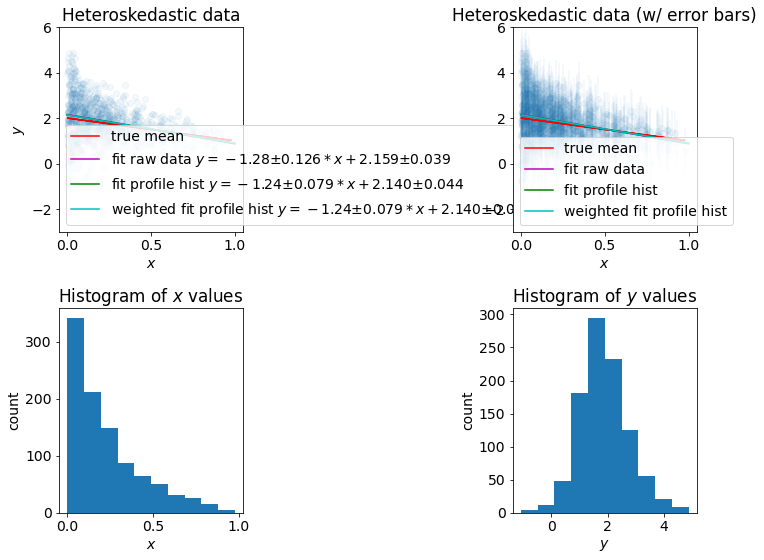

In [534]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.RandomState(42)
x = rng.exponential(scale=0.25, size=1000)
x = x[x <= 1]
y_true_mean = 2 - 1 * x
y = y_true_mean + rng.normal(loc=0, scale=0.2 + 0.2*(x+0.1)**-0.75, size=x.shape[0])
dy = np.ones_like(y)
#dy = np.random.random_sample(len(y))
#dy = dy

# adding profile hist function on simulated data
hist_x, hist_y, hist_y_err = profilehist(x, y, bins=30, uncertainty='stderr')
hist_x_err = 0.5*np.diff(x)[0]

w_hist_x, w_hist_y, w_hist_y_err = profilehist(x, y, w=1./dy**2, bins=30, uncertainty='stderr')
w_hist_x_err = 0.5*np.diff(x)[0]


#adding linregress checks
result1 = stats.linregress(x, y)
result2 = stats.linregress(hist_x, hist_y)
result3 = stats.linregress(w_hist_x, w_hist_y)


#Plotting Results

fig, axes = plt.subplots(2,2, figsize=(10,8), tight_layout=True)
#fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0,0]
#ax = axes[0]

#ax.scatter(x,y, alpha=0.05, label='heteroskedastic data', zorder=1)
ax.scatter(x,y, alpha=0.05, zorder=1)
ax.plot(x,y_true_mean, '-r', label='true mean', zorder=2)
ax.set(title='Heteroskedastic data', ylim=(-3,6), ylabel='$y$', xlabel='$x$')

#plotting linregress outputs
fit_x = np.linspace(0,1,30)
y1 = result1.slope*fit_x+result1.intercept
ax.plot(fit_x, y1, '-m', label = 'fit raw data $y=%3.5s ± %3.5s*x+%3.5s ± %3.5s$'%(result1.slope, 
                                                                                   result1.stderr,
                                                                                   result1.intercept,
                                                                                   result1.intercept_stderr))



y2 = result2.slope*fit_x+result2.intercept
ax.plot(fit_x, y2, '-g', label = 'fit profile hist $y=%3.5s ± %3.5s*x+%3.5s ± %3.5s$'%(result2.slope, 
                                                                                   result2.stderr,
                                                                                   result2.intercept,
                                                                                   result2.intercept_stderr))

y3 = result3.slope*fit_x+result3.intercept
ax.plot(fit_x, y3, '-c', label = 'weighted fit profile hist $y=%3.5s ± %3.5s*x+%3.5s ± %3.5s$'%(result3.slope, 
                                                                                   result3.stderr,
                                                                                   result3.intercept,
                                                                                   result3.intercept_stderr))
#ax.set_ylim(0, 3)
ax.legend();


ax = axes[0,1]
#ax = axes[1]

#ax.errorbar(x,y, yerr=dy, fmt='o', alpha=0.05, label='heteroskedastic data', zorder=1)
ax.errorbar(x,y, yerr=dy, fmt='o', alpha=0.05, zorder=1)
ax.plot(x,y_true_mean, '-r', label='true mean', zorder=2)
ax.set(title='Heteroskedastic data (w/ error bars)', ylim=(-3,6), xlabel='$x$')

#plotting linregress outputs
fit_x = np.linspace(0,1,30)
y1 = result1.slope*fit_x+result1.intercept
ax.plot(fit_x, y1, '-m', label = 'fit raw data')

y2 = result2.slope*fit_x+result2.intercept
ax.plot(fit_x, y2, '-g', label = 'fit profile hist')

y3 = result3.slope*fit_x+result3.intercept
ax.plot(fit_x, y3, '-c', label = 'weighted fit profile hist')

#ax.set_ylim(0, 3)
ax.legend();
        

#histograms

ax = axes[1,0]
ax.hist(x)
ax.set(xlabel='$x$', ylabel='count', title='Histogram of $x$ values')

ax = axes[1,1]
ax.hist(y)
ax.set(xlabel='$y$', ylabel='count', title='Histogram of $y$ values')


## looking at linregress in my 2D color plot for linear regressions

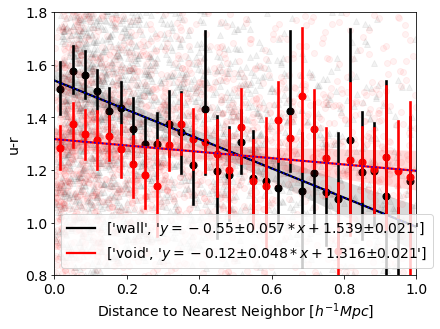

In [438]:
from scipy import stats
d_max = 1
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_table['2D_neighbor_dist'][select & sfd]
    #vals_all = dwarf_table['u_r'][select & sfd]
    
    d_all = dwarf_table['2D_neighbor_dist'][select]
    vals_all = dwarf_table['u_r'][select]

    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
    
    #slope, intercept, r_value, pv, stderr, intercept_stderr = stats.linregress(d[nonan], vals[nonan])
    
    result = stats.linregress(d[nonan], vals[nonan])
    
    
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                line_kws={'label': [label, '$y=%3.5s ± %3.5s*x+%3.5s ± %3.5s$'%(result.slope, 
                                                                                result.stderr, 
                                                                                result.intercept, 
                                                                                result.intercept_stderr)]})
    #test for linregress:
    x = xedges
    y = result.slope*x+result.intercept
    ax.plot(x, y, ':b') 
   
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='u-r', xlim=(0,1), ylim=(0.8,1.8));
        
    ax.legend(prop={'size': 14})

'''
# Z test and P Value Calculation    
    
    if c == 'k': #condition that determines whether or not you're looking at the void or wall sample
        wall_slope = result.slope
        wall_slope_err = result.stderr
        wall_intercept = result.intercept
        wall_intercept_err = result.intercept_stderr
        
    else: # 
        void_slope = result.slope
        void_slope_err = result.stderr
        void_intercept = result.intercept
        void_intercept_err = result.intercept_stderr
    
ur_slope = zscore_pvalue(wall_slope, void_slope, wall_slope_err, void_slope_err)    
ur_intercept = zscore_pvalue(wall_intercept, void_intercept, wall_intercept_err, void_intercept_err) 

print(ur_slope)
print(ur_intercept)
''';

# Code Unrelated to Hyperfit

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

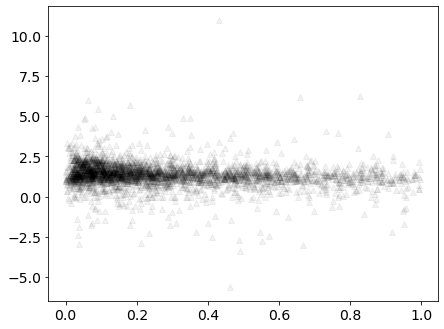

In [15]:
from scipy import stats
d_max = 1
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})

bounds = ((-1,1), (1,2), (1e-5,5))

for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_table['2D_neighbor_dist'][select & sfd]
    #vals_all = dwarf_table['u_r'][select & sfd]
    
    d_all = dwarf_table['2D_neighbor_dist'][select]
    vals_all = dwarf_table['u_r'][select]

    vals_all_err = dwarf_table['u_r_err'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    vals_err = vals_all_err[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
    
    #slope, intercept, r_value, pv, stderr, intercept_stderr = stats.linregress(d[nonan], vals[nonan])
    
    #result = stats.linregress(d[nonan], vals[nonan])
    
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label,
                #line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                #line_kws={'label': [label, '$y=%3.7s*x+%3.7s$'%(slope, intercept)]})
    
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                #line_kws={'label': [label, '$y=%3.7s*x+%3.7s$'%(result.slope, result.intercept)]})
    
    
    #xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=bins, uncertainty='sample') #if want fit on binned data
    
    
    ndata = 100 #number of bins
    x_true = d[nonan]#np.random.rand(ndata)
    y_true = vals[nonan]#np.random.normal(2.0 * x_true + 1.0, 0.2)

    # Some correlated measurements of the x and y values with different errors and correlation coefficients
    x_err, y_err, corr_xy = 0, vals_err[nonan], 
    
    #(
        #0.05 * np.random.rand(ndata) + 0.025,
        #0.05 * np.random.rand(ndata) + 0.025,
        #2.0 * (np.random.rand(ndata) - 0.5),
    #)
    
    data, cov = np.empty((2, ndata)), np.empty((2, 2, ndata))
    for i, (x, y, ex, ey, rho_xy) in enumerate(zip(x_true, y_true, x_err, y_err, corr_xy)): #make corr_xy zeros
        cov[:, :, i] = np.array([[ex ** 2, ex * ey * rho_xy], [ex * ey * rho_xy, ey ** 2]])
        data[:, i] =  ([x, y], cov[:, :, i]) #np.random.multivariate_normal([x, y], cov[:, :, i])
    
    
    hf = LinFit(data, cov)    
   
    mcmc_samples, mcmc_lnlike = hf.emcee(bounds) 
    
    slope, intercept, scatter = np.mean(mcmc_samples, axis = 1)
    
    stderr, intercept_stderr, err_scatter = np.std(mcmc_samples, axis = 1)
    
    # now make the lines 

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='u-r', xlim=(0,1), ylim=(-0.5,3));
        
    ax.legend(prop={'size': 16})
    
    #print(result.stderr)
    #print(result.intercept_stderr)
        

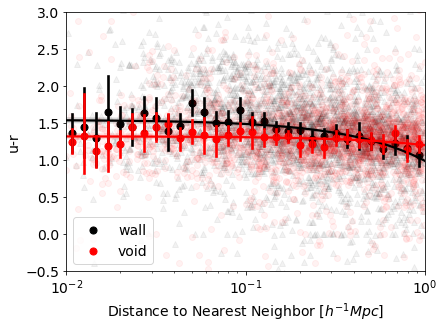

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
 
    #d_all = dwarf_table['2D_neighbor_dist'][select & sfd]
    #vals_all = dwarf_table['u_r'][select & sfd]
    
    d_all = dwarf_table['2D_neighbor_dist'][select]
    vals_all = dwarf_table['u_r'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    
    logbins = np.logspace(np.log10(0.01),np.log10(1),31) #making bins even logarithmicly  
    xcenters = 0.5*(logbins[1:] + logbins[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
          
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='u-r', xlim=(0.01,1), ylim=(-0.5,3));
    
    ax.set_xscale('log')
    
    ax.legend()
    
    #fig.savefig('sfd_ur_2D_LR_log.png')
    #fig.savefig('ur_2D_LR_log.png')

## Star Formation Rate (sSFR)

### Profile Histogram

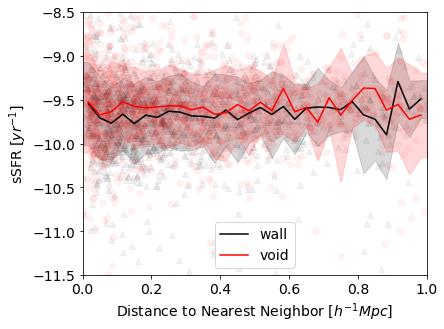

In [15]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_table['2D_neighbor_dist'][select & sfd]
    vals = dwarf_table['sSFR'][select & sfd]
    
    #d = dwarf_table['2D_neighbor_dist'][select]
    #vals = dwarf_table['sSFR'][select]
    
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,1,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='sSFR [$yr^{-1}]$', xlim=([0,1]), ylim=(-11.5,-8.5));
    ax.legend();
    

    #fig.savefig('sfd_sSFR_2D_PH.png')
    #fig.savefig('sSFR_2D_PH.png')

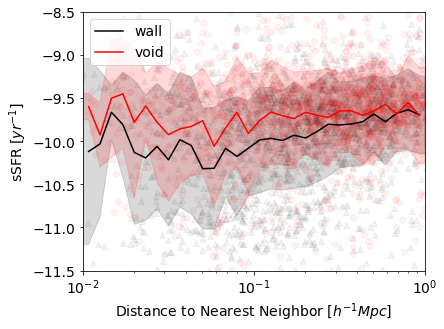

In [16]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    #d = dwarf_table['2D_neighbor_dist'][select & sfd]
    #vals = dwarf_table['sSFR'][select & sfd]
    
    d = dwarf_table['2D_neighbor_dist'][select]
    vals = dwarf_table['sSFR'][select]
    
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.logspace(np.log10(0.01),np.log10(1),31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='sSFR [$yr^{-1}]$', xlim=([0.01,1]), ylim=(-11.5,-8.5));
    ax.set_xscale('log') #changing x axis to a logarithmic scale

    ax.legend();

    #fig.savefig('sfd_sSFR_2D_PH_log.png')
    fig.savefig('sSFR_2D_PH_log.png')

### Linear Regression

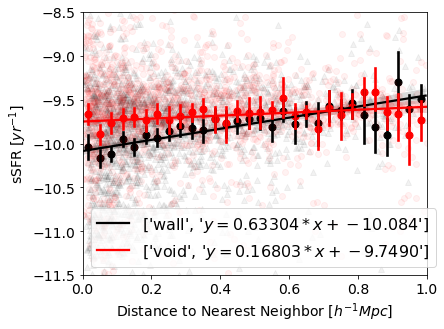

In [17]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_table['2D_neighbor_dist'][select & sfd]
    #vals_all = dwarf_table['sSFR'][select & sfd]
    
    d_all = dwarf_table['2D_neighbor_dist'][select]
    vals_all = dwarf_table['sSFR'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    #slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                #line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})    
    
    result = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                line_kws={'label': [label, '$y=%3.7s*x+%3.7s$'%(result.slope, result.intercept)]})
    
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='sSFR [$yr^{-1}]$', xlim=(0,1), ylim=(-11.5,-8.5));
        
    ax.legend(prop={'size': 16})
    
    #slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    
    #print(slope)
    
        
    #fig.savefig('sfd_sSFR_2D_LR.png')
    #fig.savefig('sSFR_2D_LR.png')

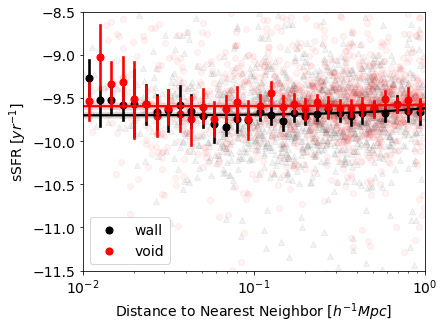

In [18]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_table['2D_neighbor_dist'][select & sfd]
    vals_all = dwarf_table['sSFR'][select & sfd]
    
    #d_all = dwarf_table['2D_neighbor_dist'][select]
    #vals_all = dwarf_table['sSFR'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    
    logbins = np.logspace(np.log10(0.01),np.log10(1),31) #making bins even logarithmicly  
    xcenters = 0.5*(logbins[1:] + logbins[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
          
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='sSFR [$yr^{-1}]$', xlim=(0.01,1), ylim=(-11.5,-8.5));
    
    ax.set_xscale('log')
    
    ax.legend()
    
    #fig.savefig('sfd_sSFR_2D_LR_log.png')
    
    #fig.savefig('sSFR_2D_LR_log.png')

## Metallicity (12 + log(O/H))

### Profile Histogram


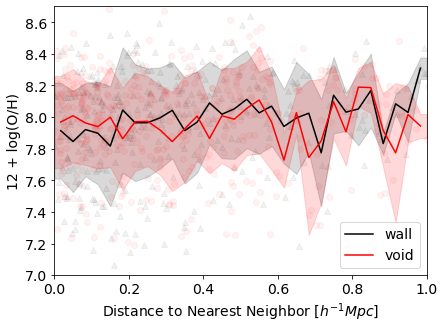

In [19]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['Z12logOH'][select & sfd_t3]
    
    #d = dwarf_t3['2D_neighbor_dist'][select]
    #vals = dwarf_t3['Z12logOH'][select]

    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,1,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='12 + log(O/H)', xlim=([0,1]), ylim=(7,8.7));
    ax.legend();

    fig.savefig('sfd_Z12logOH_2D_PH.png')
    
    #fig.savefig('Z12logOH_2D_PH.png')

C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)
C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)


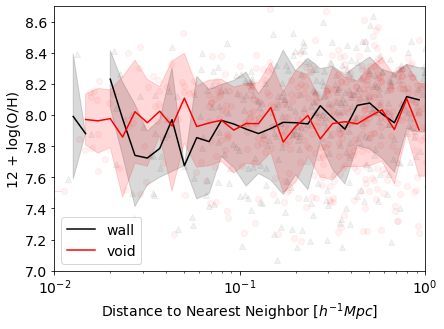

In [20]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['Z12logOH'][select & sfd_t3]
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.logspace(np.log10(0.01),np.log10(1),31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='12 + log(O/H)', xlim=([0.01,1]), ylim=(7,8.7));
    ax.set_xscale('log') #changing x axis to a logarithmic scale

    ax.legend();

    fig.savefig('sfd_Z12logOH_2D_PH_log.png')

### Linear Regression


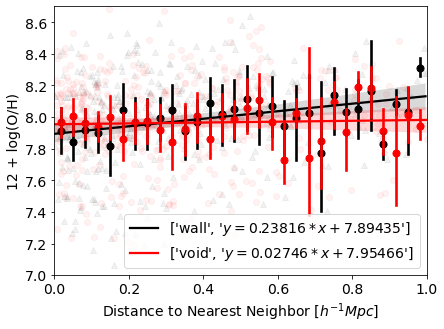

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals_all = dwarf_t3['Z12logOH'][select & sfd_t3]
    
    #d_all = dwarf_t3['2D_neighbor_dist'][select]
    #vals_all = dwarf_t3['Z12logOH'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    #slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                #line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})
    
    result = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                line_kws={'label': [label, '$y=%3.7s*x+%3.7s$'%(result.slope, result.intercept)]})

        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='12 + log(O/H)', xlim=(0,1), ylim=(7,8.7));
        
    ax.legend()
        
    fig.savefig('sfd_Z12logOH_2D_LR.png')

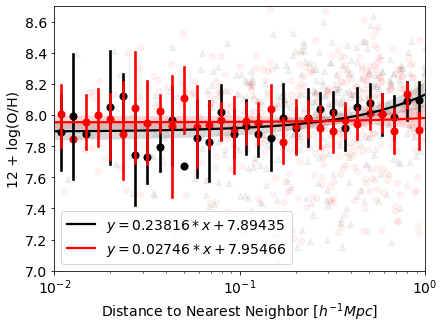

In [22]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals_all = dwarf_t3['Z12logOH'][select & sfd_t3]
    
    #d_all = dwarf_t3['2D_neighbor_dist'][select]
    #vals_all = dwarf_t3['Z12logOH'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    
    logbins = np.logspace(np.log10(0.01),np.log10(1),31) #making bins even logarithmicly  
    xcenters = 0.5*(logbins[1:] + logbins[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
     
    slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})     
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='12 + log(O/H)', xlim=(0.01,1), ylim=(7,8.7));
    
    ax.set_xscale('log')
    
    ax.legend()
    
    fig.savefig('sfd_Z12logOH_2D_LR_log.png')

## Metallicity Difference (target - neighbor)

### Profile Histogram


C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)
C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)


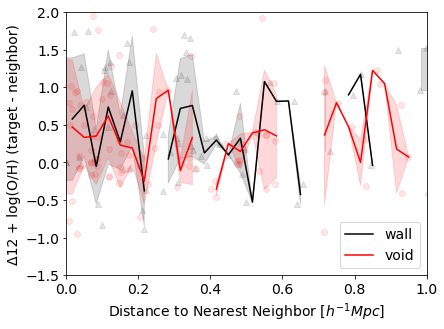

In [23]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['2D_Z12logOH_diff'][select & sfd_t3]
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,1,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='Δ12 + log(O/H) (target - neighbor)', xlim=([0,1]), ylim=(-1.5,2));
    ax.legend();

    fig.savefig('sfd_Z12logOH_diff_2D_PH.png')

### Linear Regression


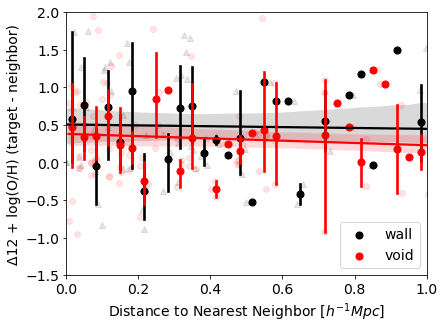

In [24]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['2D_Z12logOH_diff'][select & sfd_t3]
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
        
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='Δ12 + log(O/H) (target - neighbor)', xlim=(0,1), ylim=(-1.5,2));
        
    ax.legend()
        
    fig.savefig('sfd_Z12logOH_diff_2D_LR.png')

## N/O Ratio

### Profile Histogram

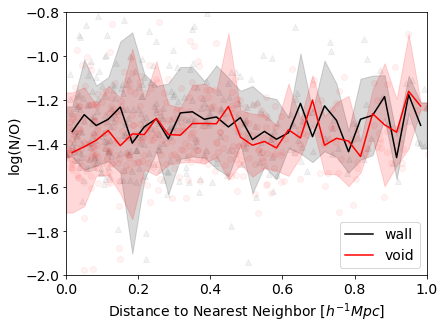

In [25]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})

for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['logNO'][select & sfd_t3]
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,1,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='log(N/O)', xlim=([0,1]), ylim=(-2,-0.8));
    ax.legend();

    fig.savefig('sfd_logNO_2D_PH.png')

C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)
C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)


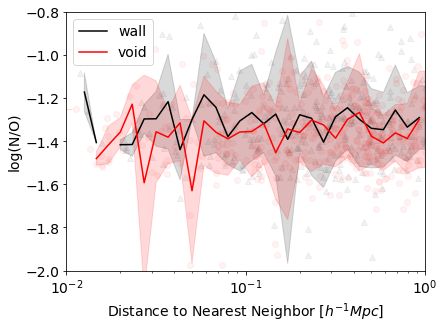

In [26]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['logNO'][select & sfd_t3]
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.logspace(np.log10(0.01),np.log10(1),31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='log(N/O)', xlim=([0.01,1]), ylim=(-2,-0.8));
    ax.set_xscale('log') #changing x axis to a logarithmic scale

    ax.legend();

    fig.savefig('sfd_logNO_2D_PH_log.png')

### Linear Regression

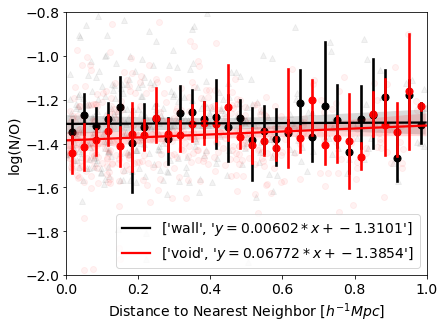

In [27]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals_all = dwarf_t3['logNO'][select & sfd_t3]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    #slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                #line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})
    
    result = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax,  
                line_kws={'label': [label, '$y=%3.7s*x+%3.7s$'%(result.slope, result.intercept)]})
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='log(N/O)', xlim=(0,1), ylim=(-2,-0.8));
        
    ax.legend()
        
    fig.savefig('sfd_logNO_2D_LR.png')

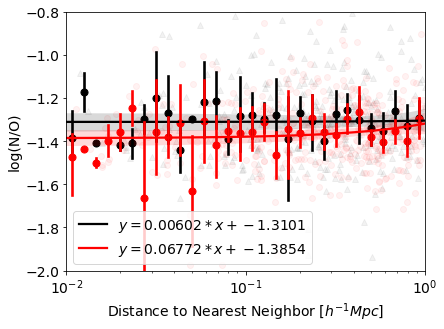

In [28]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals_all = dwarf_t3['logNO'][select & sfd_t3]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    logbins = np.logspace(np.log10(0.01),np.log10(1),31) #making bins even logarithmicly  
    xcenters = 0.5*(logbins[1:] + logbins[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})     
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='log(N/O)',
           xlim=(0.01,1), ylim=(-2,-0.8));
    
    ax.set_xscale('log')
    
    ax.legend()
        
    fig.savefig('sfd_logNO_2D_LR_log.png')

## N/O Ratio Difference (target - neighbor)

### Profile Histogram

C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)
C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:32: RuntimeWarning: invalid value encountered in true_divide
  yavg = Y/W
C:\Users\caeho\AppData\Local\Temp\ipykernel_16952\2670135367.py:33: RuntimeWarning: invalid value encountered in true_divide
  ystd = np.sqrt(E/W - yavg**2)


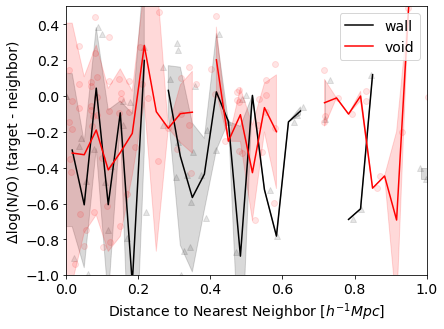

In [29]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
   
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['2D_logNO_diff'][select & sfd_t3]
    nonan = ~np.isnan(vals)

    xc, yavg, yerr = profilehist(d[nonan], vals[nonan], bins=np.linspace(0,1,31), uncertainty='sample')
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
    #ax.errorbar(xc, yavg, yerr=yerr, fmt='o', color=mc, label=label)
    
    ax.plot(xc, yavg, c, label = label )
    ax.fill_between([0, *xc, 1], 
                   np.array([yavg[0], *yavg, yavg[-1]]) + np.array([yerr[0], *yerr, yerr[-1]]),
                   np.array([yavg[0], *yavg, yavg[-1]]) - np.array([yerr[0], *yerr, yerr[-1]]),
                   color = c, alpha = 0.15)

    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='Δlog(N/O) (target - neighbor)', xlim=([0,1]), ylim=(-1,0.5));
    ax.legend();

    fig.savefig('sfd_logNO_diff_2D_PH.png')

### Linear Regression

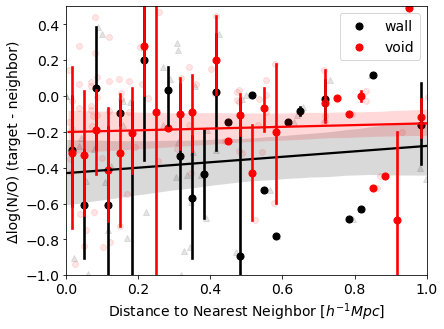

In [30]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals = dwarf_t3['2D_logNO_diff'][select & sfd_t3]
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.1, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
        
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='Δlog(N/O) (target - neighbor)', xlim=(0,1), ylim=(-1,0.5));
        
    ax.legend()
        
    fig.savefig('sfd_logNO_diff_2D_LR.png')